# CS145: Project 2 | Traffic Fatalaties Across the United States

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Leon MacAlister, leonmac*
* *Jonathan Affeld, jaffeld*

## Project Overview

---
**MAIN QUESTION**

Are Traffic Fatalities consistent across the United States or are there specific states with Higher or Lower fatality rates? What factors might contribute to these regional variations?

**PROJECT OVERVIEW**

We are using the nhtsa_traffic_fatalities data set to find which factors significantly increase the severity of fatal crashes such as atmospheric conditions, emergency response times and how it differs across state. To do this we will try to find out how a wide range of factors along with their combinations, along with a way to measure the severity of a fatal accident. Moreover we want to find which are the most common factors that are involved within car accidents. 

**SUPPLEMENTARY QUESTIONS**
- Are the number of deaths in a crash determined by the emergency response time? Perhaps the severity of a crash may be very contingent upon the effectiveness of emergency services or proximity to hospitals where emergency care can be provided. And does emergency response time on average differ from state to state?

- What times/days are the most fatal, and what proportion of those crashes during those times involve drunk drivers. We wonder if there are more drunk drivers in certain states? And if hours with most fatal crashes vary across these states?

- What atmospheric conditions cause a higher percentage of severe crashes? And do differences in unfavourable conditions across states increase number of fatal crashes in a statistically significant way?

- Does maneuvering increase or decrease the number of fatalities in a crash? Or is it more of an indicator of whether or not someone is drunk/impaired?
Being alert may cause someone to swerve as opposed to being drunk/asleep, we also wonder if swerving leads to more or less deaths on the road.

- Which contributing factors and their combinations are most common in severe/fatal crashes (find various permutations of contributing factors)? We want to know if a combination of factors such as being impaired + being distracted result or being impaired + swerving will result in more severe crashes 



---


# Analysis of Dataset

In [ ]:
!pip install pandas
!pip install pandas-gbq
!pip install matplotlib
!pip install plotly
!pip install plotly-express

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.oauth2 import service_account
key_path = './cs145-project2-406000-9a59fc7c0b3d.json'
credential = service_account.Credentials.from_service_account_file(key_path)

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
%load_ext google.cloud.bigquery
%env GOOGLE_APPLICATION_CREDENTIALS=$key_path
project_id = "cs145-project2-406000"
client = bigquery.Client(credentials=credential, project=project_id)

### Taste of the Dataset (just using 2016)

ACCIDENTS (~30mb each for 6 years - 180mb)
State_name (primary)
Number_of_motor_vehicles_in_transport_mvit (primary)
Number_of_parked_working_vehicles (primary)
Number_of_persons_in_motor_vehicles_in_transport_mvit (primary)
Number_of_persons_not_in_motor_vehicles_in_transport_mvit (primary)
City_name (primary)
Day_name (primary)
Month_of_crash_name (primary)
Day_of_week_name (primary)
Hour_of_crash_name (primary)
Route_signing_name (primary)
Land_use (primary) 
Land_use_name (primary) *Very vague e.g. rural, urban etc.
First_harmful_event_name (primary) 
Work_zone (primary)
Work_zone_name (primary)
Relation_to_trafficway_name (primary)
Light_condition_name (primary)
Atmospheric_conditions_name (primary)
Minute_of_arrival_at_scene (primary) *MAKE A NEW FEATURE DIFFERENCE BETWEEN CRASH TIME AND ARRIVAL AT SCENE
Minute_of_ems_arrival_at_hospital_name (primary) *MAKE A NEW FEATURE DIFFERENCE BETWEEN CRASH TIME AND ARRIVAL AT SCENE
Number_of_fatalities (primary)
Number_of_drunk_drivers (primary)

ACCIDENTS is the main table of the dataset. It has a high level description of each crash e.g. when, where, and some description of the actual crash. Moreover it gives us a handful of other useful columns such as atmospheric condition which indicates if it was raining, cloudy etc. Another column like light_condition gives information on how bright or dark it is on a numerical scale (e.g. dark and lighted, dusk, daylight etc.). However the more interesting columns are the crash time and arrival of emergency services at the scene - which may give us a lot of insight into how the quickness of emergency response can help reduce the number of fatalities in a car accident. Also note that the consecutive number is the code for the crash, which includes all cars involved in that particular accident. We will also use this identification number to join all the other tables to make the dataset more robust. There are some data inconsistencies from year to year, but we are mainly choosing to exclude 2015 as there are a couple of columns missing from this dataset that we will be using. So we will be drawing quantitative insights from five years of data, not six.

Moreover we need to be mindful that since there are multiple victims or participants in a fatal car accident, that there may be several rows in other tables below that refer to the same crash but for a different vehicle. For example in a three way crash, DISTRACT will include an entry for all three drivers. This is the same for other tables as well like MANEUVER etc. Therefore it is crucial we keep this in mind when we query data or train a model.

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2016`
LIMIT 5


CEVENT (~14mb over 6 years - 84mb)
state_number
state_name
consecutive_number
event_number
vehicle_number_this_vehicle
area_of_impact_this_vehicle
area_of_impact_this_vehicle_name
sequence_of_events
sequence_of_events_name
vehicle_number_other_vehicle
vehicle_number_other_vehicle_name
area_of_impact_other_vehicle
area_of_impact_other_vehicle_name

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. cevent_2016`
LIMIT 5

DAMAGE (~11.5mb over 6 years - 69mb)
state_number
state_name
consecutive_number
vehicle_number
damaged_areas
damaged_areas_name

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. damage_2016`
LIMIT 5

DISTRACT (~3mb over 6 years - 18mb)
Consecutive_number  (secondary)
Vehicle_number  (secondary)
Driver_distracted_by_name (primary)

This is a simple add on where we can join consecutive numbers to the accidents table. Here the driver_distracted_by_name will give us information on whether or not the driver was distracted. If not it will give us “not reported” or “unknown”. Or if the driver was distracted, will give us the source of distraction e.g. “distracted by an outside person”. 

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. distract_2016`
LIMIT 5

DRIMPAIR (~3.5mb over 6 years - 21mb)
Consecutive_number  (secondary)
Vehicle_number  (secondary)
Condition_impairment_at_time_of_crash_driver_name (primary)

This is another add on table where we can join consecutive numbers to the accidents table. Here the table will give us information on whether or not the driver had a physical impairment that may have contributed to the crash. If not it will give us “None/Apparently Normal” or “unknown”. 

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. drimpair_2016`
LIMIT 5

FACTOR (~2.5mb over 6 years - 15mb)
state_number (Secondary)
state_name (Secondary)
consecutive_number (Secondary)
vehicle_number (Secondary)
contributing_circumstances_motor_vehicle (primary)
contributing_circumstances_motor_vehicle_name (primary)

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. factor_2016`
LIMIT 5

MANEUVER (~3mb over 6 years - 18mb)
Consecutive_number  (secondary)
Vehicle_number  (secondary)
Driver_maneuvered_to_avoid_name (primary)

Another add on where we can join consecutive numbers to the accidents table. Here the table will give us information on whether or not the driver maneuvered to avoid an object or car e.g. “motor vehicle”


In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. maneuver_2016`
LIMIT 5

NMCRASH (~<1mb over 6 years - 5mb)
Consecutive_number  (secondary)
Vehicle_number  (secondary)
Non_motorist_contributing_circumstances_name (primary)

Another add on where we can join consecutive numbers to the accidents table. Here the table will give us information on how a non_motorist may have contributed to a crash. For example if a pedestrian was wearing “dark clothes” or not.

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. nmcrash_2016`
LIMIT 5

NMIMPAIR (0.5mb over 6 years - 3mb)
state_number (secondary)
state_name (secondary)
consecutive_number (secondary)
vehicle_number (secondary)
person_number (primary)
condition_impairment_at_time_of_crash_non_motorist (primary)
condition_impairment_at_time_of_crash_non_motorist_name (primary)

Here this details whether or not a non motorist's impairments contributed to a crash and what that impairment was

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. nmimpair_2016`
LIMIT 5

PBTYPE (~3.5mb over 6 years - 21mb)
state_number
state_name
consecutive_number
vehicle_number
person_number
person_type
person_type_name
age
age_name
sex
sex_name
marked_crosswalk_present
marked_crosswalk_present_name
sidewalk_present
sidewalk_present_name
school_zone
school_zone_name
crash_type_pedestrian
crash_type_pedestrian_name
crash_type_bicycle
crash_type_bicycle_name
crash_location_pedestrian
crash_location_pedestrian_name
crash_location_bicycle
crash_location_bicycle_name
pedestrian_position
pedestrian_position_name
bicyclist_position
bicyclist_position_name
pedestrian_initial_direction_of_travel
pedestrian_initial_direction_of_travel_name
bicyclist_initial_direction_of_travel
bicyclist_initial_direction_of_travel_name
motorist_initial_direction_of_travel
motorist_initial_direction_of_travel_name
motorist_maneuver
motorist_maneuver_name
intersection_leg
intersection_leg_name
pedestrian_scenario
pedestrian_scenario_name
crash_group_pedestrian
crash_group_pedestrian_name
crash_group_bicycle
crash_group_bicycle_name

Pedestrian/cyclist information involved in crash

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. pbtype_2016`
LIMIT 5

SAFETYEQ (~0.5mb over 6 years - 3mb)
state_number (secondary)
state_name (secondary)
consecutive_number (secondary)
vehicle_number (secondary)
person_number (secondary)
non_motorist_safety_equipment_use (primary)
non_motorist_safety_equipment_use_name (primary)

If safety equipment was used and the name of it e.g. seatbelt etc.

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. safetyeq_2016`
LIMIT 5

VEVENT (~20mb over 6 years - 120mb)
state_number
state_name
consecutive_number
event_number
vehicle_number
vehicle_event_number
vehicle_number_this_vehicle
area_of_impact_this_vehicle
area_of_impact_this_vehicle_name
sequence_of_events
sequence_of_events_name
vehicle_number_other_vehicle
vehicle_number_other_vehicle_name
area_of_impact_other_vehicle
area_of_impact_other_vehicle_name

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. vevent_2016`
LIMIT 5

VIOLATION (~2.5mb over 6 years - 15mb)
Consecutive_number  (secondary)
Vehicle_number  (secondary)
Violations_charged_name (primary)

An add on where we can join consecutive numbers to the accidents table. This delineates the number and type of road rule violations that occurred e.g. “no license plate”. 

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. violation_2016`
LIMIT 5

VISION (~3mb over 6 years - 18mb)
Consecutive_number  (secondary)
Vehicle_number  (secondary)
Drivers_vision_obscured_by_name (primary)

An add on where we can join consecutive numbers to the accidents table. This delineates the number and type of vision obstruction that occurred and contributed to the car accident e.g. “reflected glare, bright sunlight”. 

In [267]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. vision_2016`
LIMIT 5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,state_number,state_name,consecutive_number,vehicle_number,drivers_vision_obscured_by,drivers_vision_obscured_by_name
0,1,Alabama,10264,5,0,No Obstruction Noted
1,1,Alabama,10762,5,0,No Obstruction Noted
2,1,Alabama,10762,6,0,No Obstruction Noted
3,1,Alabama,10845,5,0,No Obstruction Noted
4,1,Alabama,10878,5,0,No Obstruction Noted


VSOE (~10mb over 6 years - 60mb)
state_number (secondary)
state_name (secondary)
consecutive_number (secondary)
vehicle_number (secondary)
vehicle_event_number (primary)
sequence_of_events (primary)
sequence_of_events_name (primary)
area_of_Impact_associated_with_the_event (primary)
area_of_Impact_associated_with_the_event_name (primary)

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.nhtsa_traffic_fatalities. vsoe_2016`
LIMIT 5

**Issues/Inconsistencies with the dataset** 
- CEVENT, VSOE, VEVENT seem to be describing very similar things, all including sequence of event coding for each crash (consec. number). Very detailed and descriptive data with not a lot of matching entries, hard to do much quantitative analysis on this.Quite unrelated to our question as this covers when crash actually occurs instead of contributing factors 
- For the contributing factor tables - although they all have encoded types, severity of impairment, distraction etc. is often not delineated and therefore hard to implement more gradiation in queries 
- Inconsistent type for hours, and therefore had to change it to string  
- Consecutive number provides unique ID codes for each accident, however they are reused from year to year, therefore we had to append year to these codes to ensure all accidents are unique in the aggregated table we made
- No data for the state of Indiana 


**Pivoting Away From Using Other Tables Outside of Accidents**
- We initially joined several tables on consecutive number to ACCIDENTS including DRIMPAIR, DISTRACT, VIOLATIONS, VISION, NMIMPAIR etc. Consecutive number gives us the ID of a specific crash.
- As aforementioned to overcome the fact that IDs get re-used from year to year, we appended the year number to the consecutive number to ensure that all accidents are unique 
-Moreover for certain tables such as nmcrash, drimpair, nmimpair, and violation we must account for the fact that if there are multiple participants within an accident there will be multiple entries for a specific accident id number. 
 e.g. if there is a head-on collision, there will be row entries for both drivers in drimpair table under the same accident ID that states if either driver was physically impaired or not. Therefore when joining tables that have many entries for the same accident we get several duplicates and permutations that add extreme bulk to our dataset. This resulted in certain specific crashes having thousands of different entries after joining on multiple different tables due to the sheer amount of permutations. 
- Hence we decided to cut down on the number of feature tables to join on to ACCIDENTS to just two: DISTRACT and DRIMPAIR. However we continued to encounter more data consistency issues.
- In the end we decided to use just the ACCIDENTS table and join across years as it already had a swathe of interesting features.





----
# Analysis of Dataset
----

## Investigate how we should create our car severity equation

Below is a query that aims to investigate the number of accidents with different numbers of vehicles in transport. As we can see here, most accidents involve one car. And number of accidents increase as number of motor vehicles in transport decreases. Ultimately we want to see if number of vehicles in transport involved in accident should be used to determine crash severity. 

In [ ]:
%%bigquery --project $project_id

SELECT number_of_motor_vehicles_in_transport_mvit, COUNT(number_of_motor_vehicles_in_transport_mvit) AS count
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2016`
GROUP BY number_of_motor_vehicles_in_transport_mvit
ORDER BY number_of_motor_vehicles_in_transport_mvit

Below is a query that aims to investigate the number of accidents with different numbers of vehicles that are parked.

In [ ]:
%%bigquery --project $project_id

SELECT number_of_parked_working_vehicles, COUNT(number_of_parked_working_vehicles) AS count
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2016`
GROUP BY number_of_parked_working_vehicles
ORDER BY number_of_parked_working_vehicles

We also wanted to see how accidents were stratified by number of fatalities. Below we noticed that like number of vehicles involved (which makes sense), number of fatalities in an accident is mostly 1. As such we see that most fatal accidents in the US do not involve more than just the driver.

In [ ]:
%%bigquery --project $project_id

SELECT number_of_fatalities, COUNT(number_of_fatalities) AS count
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2016`
GROUP BY number_of_fatalities
ORDER BY number_of_fatalities

When determining the label, we were disappointed to find that the data set only includes accidents with fatalities. We could do so much more with a dataset that included accidents with and without fatalities. We found that in the vast majority of the dataset, entries only had one fatality, thus determining severity purely based on number of fatalities would not be realistic for a model.

 Just so we intitially decided to artificially make a label variable that estimates the severity of a crash and creates a nice distribution between low severity and high severity. We let the severity = LOG(number_of_motor_vehicles_in_transport_mvit) + 2 * LOG(number_of_parked_working_vehicles + 1) + number_of_fatalities = 1. This is because vehicles that are parked are less likely to have occupants. Moreover we think the number of injuries and damage caused will greatly increase with number of moving vehicles in the crash. Finally we weight the number of fatalities in an accident the most for obvious reasons. Below we see that the data is still slightly biased towards "low severity fatal accidents". 

Nevertheless we decided the number here was too abstract, and therefore opted to choose our label to simply be the number of fatalities within an accident - as we think this is the most simple way to determine the severity of fatal car accidents.

In [ ]:
%%bigquery --project $project_id

SELECT IF(number_of_motor_vehicles_in_transport_mvit + number_of_parked_working_vehicles > 1 OR number_of_fatalities > 1, 1, 0) AS label, COUNT(*) AS count
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2016`
GROUP BY label

----
# Exploration of our Dataset
----

## Aggregate the Data we want into one Table

- We unioned all the accident tables from year to year (2015-2020) to make a master accidents table. As a result we got ~200,000 fatal accidents for a total of ~300mb
- We made number of fatalities the label
- As aforementioned we noticed that the consecutive numbers (the unique ID code for a specific accident within a given year) are reused from year to year. To overcome this fact we appended the year number to the consecutive number to ensure that all accidents are unique when we join by year.

- We excluded table from 2015 as it was missing some crucial columns.

- We noticed that there was an Emergency Arrival at Scene Column, along with time of accident. And therefore to find the Emergency response time we found the difference between the two, accounting for different unit of measurement types (see time_to_scene below)




In [ ]:
%%bigquery --project $project_id
CREATE OR REPLACE TABLE traffic_fatalities.traffic_features AS
SELECT
  CONCAT(accident2015.consecutive_number, accident2015.year_of_crash) AS id,    
  accident2015.state_number,
  accident2015.state_name,
  accident2015.number_of_motor_vehicles_in_transport_mvit,
  accident2015.number_of_parked_working_vehicles,
  accident2015.number_of_persons_in_motor_vehicles_in_transport_mvit,
  accident2015.number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  accident2015.day_name,
  accident2015.month_of_crash_name,
  accident2015.day_of_week_name,
  accident2015.hour_of_crash_name,
  accident2015.land_use_name,
  accident2015.light_condition_name,
  accident2015.atmospheric_conditions_name,
  IF(accident2015.hour_of_notification > 23 OR accident2015.minute_of_notification > 59 OR accident2015.hour_of_arrival_at_scene > 23 OR accident2015.minute_of_arrival_at_scene > 59, 9999, (IF(accident2015.hour_of_notification <= accident2015.hour_of_arrival_at_scene, accident2015.hour_of_arrival_at_scene - accident2015.hour_of_notification, accident2015.hour_of_arrival_at_scene - accident2015.hour_of_notification + 24) * 60 + IF(accident2015.minute_of_notification <= accident2015.minute_of_arrival_at_scene, accident2015.minute_of_arrival_at_scene - accident2015.minute_of_notification, accident2015.minute_of_arrival_at_scene - accident2015.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2015.hour_of_notification > 23 OR accident2015.minute_of_notification > 59 OR accident2015.hour_of_ems_arrival_at_hospital > 23 OR accident2015.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2015.hour_of_notification <= accident2015.hour_of_ems_arrival_at_hospital, accident2015.hour_of_ems_arrival_at_hospital - accident2015.hour_of_notification, accident2015.hour_of_ems_arrival_at_hospital - accident2015.hour_of_notification + 24) * 60 + IF(accident2015.minute_of_notification <= accident2015.minute_of_ems_arrival_at_hospital, accident2015.minute_of_ems_arrival_at_hospital - accident2015.minute_of_notification, accident2015.minute_of_ems_arrival_at_hospital - accident2015.minute_of_notification + 60))) AS time_to_hospital,
  accident2015.number_of_drunk_drivers,
  accident2015.number_of_fatalities,
  accident2015.number_of_fatalities AS label
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2015` AS accident2015
UNION ALL
-- (Your next query or continuation of the script)
SELECT
  CONCAT(accident2016.consecutive_number, accident2016.year_of_crash) AS id,    
  accident2016.state_number,
  accident2016.state_name,
  accident2016.number_of_motor_vehicles_in_transport_mvit,
  accident2016.number_of_parked_working_vehicles,
  accident2016.number_of_persons_in_motor_vehicles_in_transport_mvit,
  accident2016.number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  accident2016.day_name,
  accident2016.month_of_crash_name,
  accident2016.day_of_week_name,
  accident2016.hour_of_crash_name,
  accident2016.land_use_name,
  accident2016.light_condition_name,
  accident2016.atmospheric_conditions_name,
  IF(accident2016.hour_of_notification > 23 OR accident2016.minute_of_notification > 59 OR accident2016.hour_of_arrival_at_scene > 23 OR accident2016.minute_of_arrival_at_scene > 59, 9999, (IF(accident2016.hour_of_notification <= accident2016.hour_of_arrival_at_scene, accident2016.hour_of_arrival_at_scene - accident2016.hour_of_notification, accident2016.hour_of_arrival_at_scene - accident2016.hour_of_notification + 24) * 60 + IF(accident2016.minute_of_notification <= accident2016.minute_of_arrival_at_scene, accident2016.minute_of_arrival_at_scene - accident2016.minute_of_notification, accident2016.minute_of_arrival_at_scene - accident2016.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2016.hour_of_notification > 23 OR accident2016.minute_of_notification > 59 OR accident2016.hour_of_ems_arrival_at_hospital > 23 OR accident2016.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2016.hour_of_notification <= accident2016.hour_of_ems_arrival_at_hospital, accident2016.hour_of_ems_arrival_at_hospital - accident2016.hour_of_notification, accident2016.hour_of_ems_arrival_at_hospital - accident2016.hour_of_notification + 24) * 60 + IF(accident2016.minute_of_notification <= accident2016.minute_of_ems_arrival_at_hospital, accident2016.minute_of_ems_arrival_at_hospital - accident2016.minute_of_notification, accident2016.minute_of_ems_arrival_at_hospital - accident2016.minute_of_notification + 60))) AS time_to_hospital,
  accident2016.number_of_drunk_drivers,
  accident2016.number_of_fatalities,
  accident2016.number_of_fatalities AS label
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2016` AS accident2016
UNION ALL
SELECT
  CONCAT(accident2017.consecutive_number, accident2017.year_of_crash) AS id,    
  accident2017.state_number,
  accident2017.state_name,
  accident2017.number_of_motor_vehicles_in_transport_mvit,
  accident2017.number_of_parked_working_vehicles,
  accident2017.number_of_persons_in_motor_vehicles_in_transport_mvit,
  accident2017.number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  accident2017.day_name,
  accident2017.month_of_crash_name,
  accident2017.day_of_week_name,
  accident2017.hour_of_crash_name,
  accident2017.land_use_name,
  accident2017.light_condition_name,
  accident2017.atmospheric_conditions_name,
  IF(accident2017.hour_of_notification > 23 OR accident2017.minute_of_notification > 59 OR accident2017.hour_of_arrival_at_scene > 23 OR accident2017.minute_of_arrival_at_scene > 59, 9999, (IF(accident2017.hour_of_notification <= accident2017.hour_of_arrival_at_scene, accident2017.hour_of_arrival_at_scene - accident2017.hour_of_notification, accident2017.hour_of_arrival_at_scene - accident2017.hour_of_notification + 24) * 60 + IF(accident2017.minute_of_notification <= accident2017.minute_of_arrival_at_scene, accident2017.minute_of_arrival_at_scene - accident2017.minute_of_notification, accident2017.minute_of_arrival_at_scene - accident2017.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2017.hour_of_notification > 23 OR accident2017.minute_of_notification > 59 OR accident2017.hour_of_ems_arrival_at_hospital > 23 OR accident2017.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2017.hour_of_notification <= accident2017.hour_of_ems_arrival_at_hospital, accident2017.hour_of_ems_arrival_at_hospital - accident2017.hour_of_notification, accident2017.hour_of_ems_arrival_at_hospital - accident2017.hour_of_notification + 24) * 60 + IF(accident2017.minute_of_notification <= accident2017.minute_of_ems_arrival_at_hospital, accident2017.minute_of_ems_arrival_at_hospital - accident2017.minute_of_notification, accident2017.minute_of_ems_arrival_at_hospital - accident2017.minute_of_notification + 60))) AS time_to_hospital,
  accident2017.number_of_drunk_drivers,
  accident2017.number_of_fatalities,
  accident2017.number_of_fatalities AS label
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2017` AS accident2017
UNION ALL
SELECT
  CONCAT(accident2018.consecutive_number, accident2018.year_of_crash) AS id,    
  accident2018.state_number,
  accident2018.state_name,
  accident2018.number_of_motor_vehicles_in_transport_mvit,
  accident2018.number_of_parked_working_vehicles,
  accident2018.number_of_persons_in_motor_vehicles_in_transport_mvit,
  accident2018.number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  accident2018.day_name,
  accident2018.month_of_crash_name,
  accident2018.day_of_week_name,
  accident2018.hour_of_crash_name,
  accident2018.land_use_name,
  accident2018.light_condition_name,
  accident2018.atmospheric_conditions_name,
  IF(accident2018.hour_of_notification > 23 OR accident2018.minute_of_notification > 59 OR accident2018.hour_of_arrival_at_scene > 23 OR accident2018.minute_of_arrival_at_scene > 59, 9999, (IF(accident2018.hour_of_notification <= accident2018.hour_of_arrival_at_scene, accident2018.hour_of_arrival_at_scene - accident2018.hour_of_notification, accident2018.hour_of_arrival_at_scene - accident2018.hour_of_notification + 24) * 60 + IF(accident2018.minute_of_notification <= accident2018.minute_of_arrival_at_scene, accident2018.minute_of_arrival_at_scene - accident2018.minute_of_notification, accident2018.minute_of_arrival_at_scene - accident2018.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2018.hour_of_notification > 23 OR accident2018.minute_of_notification > 59 OR accident2018.hour_of_ems_arrival_at_hospital > 23 OR accident2018.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2018.hour_of_notification <= accident2018.hour_of_ems_arrival_at_hospital, accident2018.hour_of_ems_arrival_at_hospital - accident2018.hour_of_notification, accident2018.hour_of_ems_arrival_at_hospital - accident2018.hour_of_notification + 24) * 60 + IF(accident2018.minute_of_notification <= accident2018.minute_of_ems_arrival_at_hospital, accident2018.minute_of_ems_arrival_at_hospital - accident2018.minute_of_notification, accident2018.minute_of_ems_arrival_at_hospital - accident2018.minute_of_notification + 60))) AS time_to_hospital,
  accident2018.number_of_drunk_drivers,
  accident2018.number_of_fatalities,
  accident2018.number_of_fatalities AS label
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2018` AS accident2018
UNION ALL
SELECT
  CONCAT(accident2019.consecutive_number, accident2019.year_of_crash) AS id,    
  accident2019.state_number,
  accident2019.state_name,
  accident2019.number_of_motor_vehicles_in_transport_mvit,
  accident2019.number_of_parked_working_vehicles,
  accident2019.number_of_persons_in_motor_vehicles_in_transport_mvit,
  accident2019.number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  accident2019.day_name,
  accident2019.month_of_crash_name,
  accident2019.day_of_week_name,
  accident2019.hour_of_crash_name,
  accident2019.land_use_name,
  accident2019.light_condition_name,
  accident2019.atmospheric_conditions_name,
  IF(accident2019.hour_of_notification > 23 OR accident2019.minute_of_notification > 59 OR accident2019.hour_of_arrival_at_scene > 23 OR accident2019.minute_of_arrival_at_scene > 59, 9999, (IF(accident2019.hour_of_notification <= accident2019.hour_of_arrival_at_scene, accident2019.hour_of_arrival_at_scene - accident2019.hour_of_notification, accident2019.hour_of_arrival_at_scene - accident2019.hour_of_notification + 24) * 60 + IF(accident2019.minute_of_notification <= accident2019.minute_of_arrival_at_scene, accident2019.minute_of_arrival_at_scene - accident2019.minute_of_notification, accident2019.minute_of_arrival_at_scene - accident2019.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2019.hour_of_notification > 23 OR accident2019.minute_of_notification > 59 OR accident2019.hour_of_ems_arrival_at_hospital > 23 OR accident2019.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2019.hour_of_notification <= accident2019.hour_of_ems_arrival_at_hospital, accident2019.hour_of_ems_arrival_at_hospital - accident2019.hour_of_notification, accident2019.hour_of_ems_arrival_at_hospital - accident2019.hour_of_notification + 24) * 60 + IF(accident2019.minute_of_notification <= accident2019.minute_of_ems_arrival_at_hospital, accident2019.minute_of_ems_arrival_at_hospital - accident2019.minute_of_notification, accident2019.minute_of_ems_arrival_at_hospital - accident2019.minute_of_notification + 60))) AS time_to_hospital,
  accident2019.number_of_drunk_drivers,
  accident2019.number_of_fatalities,
  accident2019.number_of_fatalities AS label
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2019` AS accident2019
UNION ALL
SELECT
  CONCAT(accident2020.consecutive_number, accident2020.year_of_crash) AS id,    
  accident2020.state_number,
  accident2020.state_name,
  accident2020.number_of_motor_vehicles_in_transport_mvit,
  accident2020.number_of_parked_working_vehicles,
  accident2020.number_of_persons_in_motor_vehicles_in_transport_mvit,
  accident2020.number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  accident2020.day_name,
  accident2020.month_of_crash_name,
  accident2020.day_of_week_name,
  accident2020.hour_of_crash_name,
  accident2020.land_use_name,
  accident2020.light_condition_name,
  accident2020.atmospheric_conditions_1_name AS atmospheric_conditions_name,
  IF(accident2020.hour_of_notification > 23 OR accident2020.minute_of_notification > 59 OR accident2020.hour_of_arrival_at_scene > 23 OR accident2020.minute_of_arrival_at_scene > 59, 9999, (IF(accident2020.hour_of_notification <= accident2020.hour_of_arrival_at_scene, accident2020.hour_of_arrival_at_scene - accident2020.hour_of_notification, accident2020.hour_of_arrival_at_scene - accident2020.hour_of_notification + 24) * 60 + IF(accident2020.minute_of_notification <= accident2020.minute_of_arrival_at_scene, accident2020.minute_of_arrival_at_scene - accident2020.minute_of_notification, accident2020.minute_of_arrival_at_scene - accident2020.minute_of_notification + 60))) AS time_to_scene,
  IF(accident2020.hour_of_notification > 23 OR accident2020.minute_of_notification > 59 OR accident2020.hour_of_ems_arrival_at_hospital > 23 OR accident2020.minute_of_ems_arrival_at_hospital > 59, 9999, (IF(accident2020.hour_of_notification <= accident2020.hour_of_ems_arrival_at_hospital, accident2020.hour_of_ems_arrival_at_hospital - accident2020.hour_of_notification, accident2020.hour_of_ems_arrival_at_hospital - accident2020.hour_of_notification + 24) * 60 + IF(accident2020.minute_of_notification <= accident2020.minute_of_ems_arrival_at_hospital, accident2020.minute_of_ems_arrival_at_hospital - accident2020.minute_of_notification, accident2020.minute_of_ems_arrival_at_hospital - accident2020.minute_of_notification + 60))) AS time_to_hospital,
  accident2020.number_of_drunk_drivers,
  accident2020.number_of_fatalities,
  accident2020.number_of_fatalities AS label
FROM `bigquery-public-data.nhtsa_traffic_fatalities. accident_2020` AS accident2020

### Total Number of Accidents

Here we see that there are ~200,000 fatal crashes in the US from 2015-2020. This number is quite daunting, and a little higher than what we were expecting. Perhaps a shift to public transport won't just mitigate the environmental damage caused by cars - it will save many lives too...

In [ ]:
%%bigquery --project $project_id
SELECT COUNT(*)
FROM `traffic_fatalities.traffic_features`

### Total Number of Fatalitites

There have been 221137 fatalities in the past 6 years as a result of car accidents. Therefore we can infer that most fatal car accidents only result in one death. However there are still many accidents which involve multiple fatalities. 

In [ ]:
%%bigquery --project $project_id
SELECT SUM(number_of_fatalities)
FROM `traffic_fatalities.traffic_features`

### Preliminary State Investigations

As we investigate state differences, it is very important to account of the different populations. Some states may have more fatal crashes simply due to having a bigger population. Just so, we will join on 5 year census data from 2020, and we join on state_number. No surprises that California, Texas and Florida have the biggest populations in the US.

In [268]:
%%bigquery --project $project_id

SELECT t.state_name, s.total_pop
FROM `traffic_fatalities.traffic_features` AS t
JOIN `bigquery-public-data.census_bureau_acs.state_2020_5yr` AS s ON t.state_number = CAST(s.geo_id AS INT64)
GROUP BY state_name, total_pop
ORDER BY total_pop DESC

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,state_name,total_pop
0,California,39346023.0
1,Texas,28635442.0
2,Florida,21216924.0
3,New York,19514849.0
4,Pennsylvania,12794885.0
5,Illinois,12716164.0
6,Ohio,11675275.0
7,Georgia,10516579.0
8,North Carolina,10386227.0
9,Michigan,9973907.0


ACCIDENTS PER STATE
- The below query shows the number of fatal accidents 2015-2020 by state. Comparing to the above table we can see that the number of fatal accidents are highly correlated with the population of the given state.

In [271]:
query_total_accidents_per_state = "WITH state_accidents AS (SELECT COUNT(*) AS num_accidents, state_name, state_number FROM `traffic_fatalities.traffic_features` GROUP BY state_name, state_number) SELECT f.num_accidents AS total_accidents_per_state, f.state_name, s.state FROM state_accidents AS f JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name"
total_accidents_per_state = pd.read_gbq(query_total_accidents_per_state, project_id=project_id, dialect='standard')
fig_total_accidents_per_state = px.choropleth(
    total_accidents_per_state,
    locations='state',
    locationmode='USA-states',
    color='total_accidents_per_state',
    color_continuous_scale = 'Reds',
    title='Total Accidents by State',
)

fig_total_accidents_per_state.update_layout(
    title_text = 'Accidents per State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': 'state=%{location}<br>total_accidents_per_state=%{z}<extra></extra>',
              'locationmode': 'USA-states',
              'locations': array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI',
                                  'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
                                  'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH',
                                  'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA',
                                  'WV', 'WI', 'WY'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([5193, 371, 5264, 3007, 20308, 3372, 1577, 684, 164, 17522, 8480, 573,
                          1246, 5866, 4709, 1842, 2152, 4216, 4221, 878, 3000, 1959, 5627, 2120,
                          3700, 5097, 1062, 1100, 1768, 653, 3277, 2056, 5729, 8015, 573, 6363,
                          3545, 2569, 6416, 340, 5635, 653, 5670, 20093, 1479, 328, 4565, 3059,
                          1534, 3171, 664], dtype=object)}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'total_accidents_per_state'}},
                             'colorscale': [[0.0, 'rgb(255,245,240)'], [0.125,
                                            'rgb(254,224,210)'], [0.25,
                                            'rgb(252,187,161)'], [0.375,
                                            'rgb(252,146,114)'], [0.5,
                                            'rgb(251,106,74)'], [0.625,
                                            'rgb(239,59,44)'], [0.75,
                                            'rgb(203,24,29)'], [0.875,
                                            'rgb(165,15,21)'], [1.0,
                                            'rgb(103,0,13)']]},
               'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}, 'scope': 'usa'},
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Accidents per State 2015-2020'}}
})

ACCIDENTS PER CAPITA

- Because of correlation between # accidents and state population, we must control for the differences in Population, and find which states have the highest amount of fatal accidents per person. This was done below and we now see that Mississippi has the highest incidence of fatal accidents per person in a year. Similarly, Wyoming, South Carolina, Alabama and Montana are the following states with highest amount of fatal accidents per capita. This makes us wonder whether or not this is because of higher rates of drunk driving, unfavourable atmospheric conditions, higher use of highways or just poor road education. We will investigate this further later in the project...

In [274]:
%%bigquery --project $project_id

WITH state_accidents AS (
    SELECT COUNT(*) AS num_accidents, state_name, state_number
    FROM `traffic_fatalities.traffic_features`
    GROUP BY state_name, state_number
)

SELECT f.num_accidents / p.total_pop / 6 * 100 AS accidents_per_capita_per_year, f.state_name, s.state
FROM state_accidents AS f
JOIN `bigquery-public-data.census_bureau_acs.state_2020_5yr` AS p ON f.state_number = CAST(p.geo_id AS INT64)
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name
ORDER BY accidents_per_capita_per_year DESC

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,accidents_per_capita_per_year,state_name,state
0,0.020681,Mississippi,MS
1,0.019036,Wyoming,WY
2,0.018446,South Carolina,SC
3,0.017688,Alabama,AL
4,0.016671,Montana,MT
5,0.016640,Arkansas,AR
6,0.016341,New Mexico,NM
7,0.015748,Kentucky,KY
8,0.015082,Louisiana,LA
9,0.014960,Oklahoma,OK


In [275]:
query_percent_accidents_per_state = "WITH state_accidents AS (SELECT COUNT(*) AS num_accidents, state_name, state_number FROM `traffic_fatalities.traffic_features` GROUP BY state_name, state_number) SELECT f.num_accidents / p.total_pop / 6 * 100 AS accidents_per_capita_per_year, f.state_name, s.state FROM state_accidents AS f JOIN `bigquery-public-data.census_bureau_acs.state_2020_5yr` AS p ON f.state_number = CAST(p.geo_id AS INT64) JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name"
percent_accidents_per_state = pd.read_gbq(query_percent_accidents_per_state, project_id=project_id, dialect='standard')
fig_percent_accidents_per_state = px.choropleth(
    percent_accidents_per_state,
    locations='state',
    locationmode='USA-states',
    color='accidents_per_capita_per_year',
    color_continuous_scale = 'Blues',
)

fig_percent_accidents_per_state.update_layout(
    title_text = 'Yearly Accidents Per Capita 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': 'state=%{location}<br>accidents_per_capita_per_year=%{z}<extra></extra>',
              'locationmode': 'USA-states',
              'locations': array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI',
                                  'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
                                  'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH',
                                  'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA',
                                  'WV', 'WI', 'WY'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([0.01768786, 0.00838998, 0.01222924, 0.0166397 , 0.00860231, 0.00988579,
                          0.00736115, 0.01178077, 0.00389378, 0.01376417, 0.0134391 , 0.006725  ,
                          0.01183713, 0.00768838, 0.01171936, 0.009746  , 0.01231423, 0.01574797,
                          0.01508163, 0.01091368, 0.0082814 , 0.00475047, 0.00940287, 0.00630934,
                          0.02068078, 0.01387129, 0.0166713 , 0.00952962, 0.00972407, 0.00803053,
                          0.00614678, 0.01634064, 0.00489286, 0.01286158, 0.01255928, 0.0090833 ,
                          0.0149603 , 0.01025218, 0.00835751, 0.00535704, 0.01844571, 0.01237676,
                          0.01395397, 0.01169472, 0.00782232, 0.00875591, 0.00894114, 0.0067865 ,
                          0.01414535, 0.00910112, 0.01903622])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'accidents_per_capita_per_year'}},
                             'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                            'rgb(222,235,247)'], [0.25,
                                            'rgb(198,219,239)'], [0.375,
                                            'rgb(158,202,225)'], [0.5,
                                            'rgb(107,174,214)'], [0.625,
                                            'rgb(66,146,198)'], [0.75,
                                            'rgb(33,113,181)'], [0.875,
                                            'rgb(8,81,156)'], [1.0,
                                            'rgb(8,48,107)']]},
               'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}, 'scope': 'usa'},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Yearly Accidents Per Capita 2015-2020'}}
})

FATALITIES BY STATE
- Below we conduct a similar analysis for fatalities per state 
- Here we see like accidents, it is highly correlated with population of the given state so we omitted the chart that simply shows fatalities per state - same as accidents per state
- Hence when controlling for population we expect to see that the ranking of states for traffic fatalities per capita should mirror fatal accidents per capita as well

As expected we see that the number of fatalities per capita per year is mostly the same as fatal accidents per capita per years in terms of state rankings.

In [278]:
query_percent_fatalities_per_state = "WITH state_fatalities AS (SELECT SUM(number_of_fatalities) AS num_fatalities, state_name, state_number FROM `traffic_fatalities.traffic_features`GROUP BY state_name, state_number) SELECT f.num_fatalities / p.total_pop / 6 * 100 AS fatalities_per_capita_per_year, f.state_name, s.state FROM state_fatalities AS f JOIN `bigquery-public-data.census_bureau_acs.state_2020_5yr` AS p ON f.state_number = CAST(p.geo_id AS INT64) JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name"
percent_fatalities_per_state = pd.read_gbq(query_percent_fatalities_per_state, project_id=project_id, dialect='standard')
fig_percent_fatalities_per_state = px.choropleth(
    percent_fatalities_per_state,
    locations='state',
    locationmode='USA-states',
    color='fatalities_per_capita_per_year',
    color_continuous_scale = 'Blues',
)

fig_percent_fatalities_per_state.update_layout(
    title_text = 'Yearly Fatalities Per Capita 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': 'state=%{location}<br>fatalities_per_capita_per_year=%{z}<extra></extra>',
              'locationmode': 'USA-states',
              'locations': array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI',
                                  'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
                                  'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH',
                                  'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA',
                                  'WV', 'WI', 'WY'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([0.01934663, 0.00924933, 0.01342335, 0.01824446, 0.00933936, 0.01071254,
                          0.00779059, 0.01252137, 0.00405998, 0.01482857, 0.01452469, 0.00726488,
                          0.01305314, 0.00836075, 0.01276463, 0.01079361, 0.01381918, 0.0172234 ,
                          0.01627501, 0.01175893, 0.00886662, 0.00500509, 0.01019159, 0.00683313,
                          0.02294448, 0.01500342, 0.01841378, 0.01075981, 0.01052708, 0.00865773,
                          0.00655006, 0.018264  , 0.00522935, 0.01390624, 0.01391822, 0.00980705,
                          0.01628963, 0.01128179, 0.00897885, 0.00570367, 0.01994821, 0.0141205 ,
                          0.01513525, 0.01294957, 0.00853104, 0.00963684, 0.00950718, 0.00727458,
                          0.015298  , 0.00999086, 0.02181711])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'fatalities_per_capita_per_year'}},
                             'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                            'rgb(222,235,247)'], [0.25,
                                            'rgb(198,219,239)'], [0.375,
                                            'rgb(158,202,225)'], [0.5,
                                            'rgb(107,174,214)'], [0.625,
                                            'rgb(66,146,198)'], [0.75,
                                            'rgb(33,113,181)'], [0.875,
                                            'rgb(8,81,156)'], [1.0,
                                            'rgb(8,48,107)']]},
               'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}, 'scope': 'usa'},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Yearly Fatalities Per Capita 2015-2020'}}
})

AVERAGE FATALITIES PER ACCIDENT 
- Now we want to find if there is a difference between number of fatalities per accident by state 

- Interestingly we see that the data is vastly different to the results above. Here we see that the states with the most severe fatal accidents (meaning more deaths per accident) on average are Wyoming, South Dakota, Nebraska, Kansas and New Mexico. We postulate that this may be due to combination of factors like the fact that incidence of Ice and snow may be higher in these states along with the level of alcohol comsumption. Moreover indirect factors such as level of education in these states may increase incidences of reckless driving etc.
- We see increased fatalities per fatal crash on average as states become more landlocked. We wonder if this is because of higher temperature variation for states further away from the coastline which may increase incidence of unfavourable weather conditions for driving in these states. Moreover one could also argue that the level of education may be higher along the coastlines and in states with higher population (with Texas being an outlier here) which could have a correlation with amount of reckless driving and incidence of high severity fatal crashes. In addition, as aforementioned these states may also occur in states with higher levels of drunk driving.



In [281]:
query_fatalities_accidents_per_state = "WITH state_fatalities_accidents AS (SELECT AVG(number_of_fatalities) AS avg_fatalities, state_name, state_number FROM `traffic_fatalities.traffic_features` GROUP BY state_name, state_number) SELECT f.avg_fatalities, f.state_name, s.state FROM state_fatalities_accidents AS f JOIN `bigquery-public-data.census_bureau_acs.state_2020_5yr` AS p ON f.state_number = CAST(p.geo_id AS INT64) JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name"
fatalities_accidents_per_state = pd.read_gbq(query_fatalities_accidents_per_state, project_id=project_id, dialect='standard')
fig_fatalities_accidents_per_state = px.choropleth(
    fatalities_accidents_per_state,
    locations='state',
    locationmode='USA-states',
    color='avg_fatalities',
    color_continuous_scale = 'Greens',
)

fig_fatalities_accidents_per_state.update_layout(
    title_text = 'Average Fatalities Per Accident by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': 'state=%{location}<br>avg_fatalities=%{z}<extra></extra>',
              'locationmode': 'USA-states',
              'locations': array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI',
                                  'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
                                  'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH',
                                  'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA',
                                  'WV', 'WI', 'WY'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([1.09378009, 1.10242588, 1.09764438, 1.09644164, 1.08568052, 1.08362989,
                          1.05833862, 1.0628655 , 1.04268293, 1.07733135, 1.0807783 , 1.08027923,
                          1.10272873, 1.08745312, 1.08919091, 1.10749186, 1.1222119 , 1.0936907 ,
                          1.07912817, 1.07744875, 1.07066667, 1.05359877, 1.08388129, 1.08301887,
                          1.10945946, 1.08161664, 1.10451977, 1.12909091, 1.08257919, 1.07810107,
                          1.06560879, 1.11770428, 1.06877291, 1.08122271, 1.10820244, 1.0796794 ,
                          1.08885755, 1.10042818, 1.07434539, 1.06470588, 1.08145519, 1.14088821,
                          1.08465608, 1.10730105, 1.09060176, 1.10060976, 1.06330778, 1.07191893,
                          1.08148631, 1.09776096, 1.14608434])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'avg_fatalities'}},
                             'colorscale': [[0.0, 'rgb(247,252,245)'], [0.125,
                                            'rgb(229,245,224)'], [0.25,
                                            'rgb(199,233,192)'], [0.375,
                                            'rgb(161,217,155)'], [0.5,
                                            'rgb(116,196,118)'], [0.625,
                                            'rgb(65,171,93)'], [0.75,
                                            'rgb(35,139,69)'], [0.875,
                                            'rgb(0,109,44)'], [1.0,
                                            'rgb(0,68,27)']]},
               'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}, 'scope': 'usa'},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Average Fatalities Per Accident by State 2015-2020'}}
})

### Vehicles

- In this section we want to investigate how the number of moving and parked vehicles within a fatal crash determines the number of deaths 
- We hypothesize that increased number of moving vehicles involved is directly correlated with the number of deaths within a fatal accident

- Interestingly we see that the number of moving vehicles involved in a fatal accident is more than one on average
- Just so we wonder if incidence of  fatal accidents with are highly correlated with the number of other cars on the road. This matches with our time series data below, where the day and hour with most fatalities are a combination of higher rates of drunken drivers and number of cars on the road...

In [282]:
%%bigquery --project $project_id
SELECT AVG(number_of_motor_vehicles_in_transport_mvit) AS avg_moving_vehicles
FROM `traffic_fatalities.traffic_features`

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_moving_vehicles
0,1.532509


- Average parked vehicles per accident is very small, this implies that many fatal accidents occur on roads where there are no parked vehicles such as highways and motorways. Or it is simply just rare for parked vehicles to be hit in a fatal accident for other unknown factors

In [283]:
%%bigquery --project $project_id
SELECT AVG(number_of_parked_working_vehicles) AS avg_parked_vehicles
FROM `traffic_fatalities.traffic_features`

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_parked_vehicles
0,0.040086


In [284]:
%%bigquery --project $project_id
SELECT AVG(number_of_parked_working_vehicles + number_of_motor_vehicles_in_transport_mvit) AS avg_vehicles
FROM `traffic_fatalities.traffic_features`

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_vehicles
0,1.572595


- In agreement with our hypothesis we see that nearly half of fatal accidents in the US are defined as 'multi-car' 

In [285]:
%%bigquery --project $project_id
SELECT COUNT(*)/(SELECT COUNT(*) FROM `traffic_fatalities.traffic_features`) AS percent_multicar
FROM `traffic_fatalities.traffic_features`
WHERE number_of_parked_working_vehicles + number_of_motor_vehicles_in_transport_mvit > 1

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,percent_multicar
0,0.448141


- It's surprising to see the percentage of multicar accidents varies so much from state to state
- Perhaps we see that states with higher usage of highways and interstates per capita may result in there being more multi-car fatal accidents

In [286]:
%%bigquery --project $project_id
WITH multicar AS (
    SELECT COUNT(*)/t.state_total * 100 AS percent_multicar, COUNT(*) AS num_multicar, f.state_name
    FROM `traffic_fatalities.traffic_features` AS f
    JOIN (SELECT COUNT(*) AS state_total, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON f.state_name = t.state_name
    WHERE number_of_parked_working_vehicles + number_of_motor_vehicles_in_transport_mvit > 1
    GROUP BY state_name, state_total
)
SELECT AVG(f.number_of_fatalities) AS avg_fatalities, AVG(f.number_of_parked_working_vehicles + f.number_of_motor_vehicles_in_transport_mvit) AS avg_vehicles, m.percent_multicar, m.num_multicar, f.state_name, s.state
FROM `traffic_fatalities.traffic_features` AS f
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name
JOIN multicar AS m ON f.state_name = m.state_name
GROUP BY state_name, state, m.percent_multicar, m.num_multicar
ORDER BY percent_multicar DESC

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_fatalities,avg_vehicles,percent_multicar,num_multicar,state_name,state
0,1.129091,1.684545,54.454545,599,Nebraska,NE
1,1.083881,1.626977,49.120313,2764,Michigan,MI
2,1.083019,1.587736,48.915094,1037,Minnesota,MN
3,1.089191,1.603950,48.205564,2270,Indiana,IN
4,1.079679,1.615904,48.153387,3064,Ohio,OH
5,1.062865,1.580409,47.807018,327,Delaware,DE
6,1.107301,1.610013,47.628527,9570,Texas,TX
7,1.107492,1.560803,47.448426,874,Iowa,IA
8,1.088858,1.571227,47.418900,1681,Oklahoma,OK
9,1.084656,1.585714,47.248677,2679,Tennessee,TN


In [287]:
query_multicar_per_state = "WITH multicar AS (SELECT COUNT(*)/t.state_total * 100 AS percent_multicar, COUNT(*) AS num_multicar, f.state_name FROM `traffic_fatalities.traffic_features` AS f JOIN (SELECT COUNT(*) AS state_total, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON f.state_name = t.state_name WHERE number_of_parked_working_vehicles + number_of_motor_vehicles_in_transport_mvit > 1 GROUP BY state_name, state_total) SELECT AVG(f.number_of_fatalities) AS avg_fatalities, AVG(f.number_of_parked_working_vehicles + f.number_of_motor_vehicles_in_transport_mvit) AS avg_vehicles, m.percent_multicar, m.num_multicar, f.state_name, s.state FROM `traffic_fatalities.traffic_features` AS f JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name JOIN multicar AS m ON f.state_name = m.state_name GROUP BY state_name, state, m.percent_multicar, m.num_multicar"
multicar_per_state = pd.read_gbq(query_multicar_per_state, project_id=project_id, dialect='standard')
fig_multicar_per_state = px.choropleth(
    multicar_per_state,
    locations='state',
    locationmode='USA-states',
    color='percent_multicar',
    color_continuous_scale = 'Reds',
)

fig_multicar_per_state.update_layout(
    title_text = 'Percent Multicar Accidents by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': 'state=%{location}<br>percent_multicar=%{z}<extra></extra>',
              'locationmode': 'USA-states',
              'locations': array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI',
                                  'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
                                  'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH',
                                  'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA',
                                  'WV', 'WI', 'WY'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([43.30829963, 39.35309973, 42.95212766, 43.13269039, 43.50994682,
                          44.51364176, 42.61255549, 47.80701754, 39.02439024, 47.00376669,
                          45.99056604, 40.4886562 , 42.2953451 , 46.01091033, 48.20556381,
                          47.44842562, 46.46840149, 46.01518027, 42.31224828, 35.64920273,
                          46.36666667, 38.89739663, 49.12031278, 48.91509434, 40.64864865,
                          43.79046498, 29.37853107, 54.45454545, 43.72171946, 37.21286371,
                          41.71498322, 39.20233463, 40.18153255, 44.99064255, 42.7574171 ,
                          48.15338677, 47.41889986, 41.14441417, 45.55798005, 33.23529412,
                          43.40727595, 39.50995406, 47.24867725, 47.62852735, 46.31507776,
                          39.32926829, 40.24096386, 43.41288003, 40.54758801, 46.04225796,
                          38.55421687])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'percent_multicar'}},
                             'colorscale': [[0.0, 'rgb(255,245,240)'], [0.125,
                                            'rgb(254,224,210)'], [0.25,
                                            'rgb(252,187,161)'], [0.375,
                                            'rgb(252,146,114)'], [0.5,
                                            'rgb(251,106,74)'], [0.625,
                                            'rgb(239,59,44)'], [0.75,
                                            'rgb(203,24,29)'], [0.875,
                                            'rgb(165,15,21)'], [1.0,
                                            'rgb(103,0,13)']]},
               'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}, 'scope': 'usa'},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Percent Multicar Accidents by State 2015-2020'}}
})

### People

- Like number of cars involved, we assume nunmber of passengers in a car, or pedestrians involved is highly correlated with number of deaths in a fatal accident.
- We wonder if this varies from state to state

In [ ]:
%%bigquery --project $project_id
SELECT AVG(number_of_persons_in_motor_vehicles_in_transport_mvit) AS avg_people_in_vehicles
FROM `traffic_fatalities.traffic_features`

In [ ]:
%%bigquery --project $project_id
SELECT AVG(number_of_persons_not_in_motor_vehicles_in_transport_mvit) AS avg_people_not_in_vehicles
FROM `traffic_fatalities.traffic_features`

In [ ]:
%%bigquery --project $project_id
SELECT AVG(number_of_persons_in_motor_vehicles_in_transport_mvit + number_of_persons_not_in_motor_vehicles_in_transport_mvit) AS avg_people_per_crash
FROM `traffic_fatalities.traffic_features`

In [ ]:
%%bigquery --project $project_id
SELECT COUNT(*)/(SELECT COUNT(*) FROM `traffic_fatalities.traffic_features`) * 100 AS percent_multiperson
FROM `traffic_fatalities.traffic_features`
WHERE number_of_persons_in_motor_vehicles_in_transport_mvit + number_of_persons_not_in_motor_vehicles_in_transport_mvit > 1

- Interestingly we see that California has a much higher incidence of multi-person accidents as opposed to multi-car. Perhaps the lack of public transport here incentivises increased levels of car pooling and thus the likelihood of multiple people being involved in a fatal accident

In [ ]:
%%bigquery --project $project_id
WITH multiperson AS (
    SELECT COUNT(*)/t.state_total * 100 AS percent_multiperson, COUNT(*) AS num_multiperson, f.state_name
    FROM `traffic_fatalities.traffic_features` AS f
    JOIN (SELECT COUNT(*) AS state_total, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON f.state_name = t.state_name
    WHERE number_of_persons_in_motor_vehicles_in_transport_mvit + number_of_persons_not_in_motor_vehicles_in_transport_mvit > 1
    GROUP BY state_name, state_total
)
SELECT AVG(f.number_of_fatalities) AS avg_fatalities, AVG(f.number_of_persons_in_motor_vehicles_in_transport_mvit + f.number_of_persons_not_in_motor_vehicles_in_transport_mvit) AS avg_people, m.percent_multiperson, m.num_multiperson, f.state_name, s.state
FROM `traffic_fatalities.traffic_features` AS f
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name
JOIN multiperson AS m ON f.state_name = m.state_name
GROUP BY state_name, state, m.percent_multiperson, m.num_multiperson
ORDER BY percent_multiperson DESC

In [ ]:
query_multiperson_per_state = "WITH multiperson AS (SELECT COUNT(*)/t.state_total * 100 AS percent_multiperson, COUNT(*) AS num_multiperson, f.state_name FROM `traffic_fatalities.traffic_features` AS f JOIN (SELECT COUNT(*) AS state_total, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON f.state_name = t.state_name WHERE number_of_persons_in_motor_vehicles_in_transport_mvit + number_of_persons_not_in_motor_vehicles_in_transport_mvit > 1 GROUP BY state_name, state_total) SELECT AVG(f.number_of_fatalities) AS avg_fatalities, AVG(f.number_of_persons_in_motor_vehicles_in_transport_mvit + f.number_of_persons_not_in_motor_vehicles_in_transport_mvit) AS avg_people, m.percent_multiperson, m.num_multiperson, f.state_name, s.state FROM `traffic_fatalities.traffic_features` AS f JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name JOIN multiperson AS m ON f.state_name = m.state_name GROUP BY state_name, state, m.percent_multiperson, m.num_multiperson"
multiperson_per_state = pd.read_gbq(query_multiperson_per_state, project_id=project_id, dialect='standard')
fig_multiperson_per_state = px.choropleth(
    multiperson_per_state,
    locations='state',
    locationmode='USA-states',
    color='percent_multiperson',
    color_continuous_scale = 'Reds',
)

fig_multiperson_per_state.update_layout(
    title_text = 'Percent multiperson Accidents by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

### Day of Week

- Much of our prediction here is related to drunk driving. We believe that Fridays and Saturdays will have the highest amount of fatal crashes due to this
- Interestingly Saturday and Sunday have the highest incidence of fatal crashes as opposed to Fridays and Saturday. Upon further thought this makes sense as we predict that many crashes that occur on Sunday happen between 12-4am and are alcohol related. Moreover, the spillover of partygoers on Friday into the early hours of Saturday morning bumps up the numbers for Saturday
- Thursday is the next highest day outside of "the weekend" in terms of fatal accidents. We don't know why this is, perhaps this could be due to work fatigue etc. We wonder if Thursday has the fourth highest rate of accidents that involve drunk drivers?

- As expected most states have either Saturdays, Sundays or Fridays as their deadliest days  

In [ ]:
%%bigquery --project $project_id

SELECT SUM(number_of_fatalities) AS num_fatalities, SUM(number_of_fatalities)/(SELECT SUM(number_of_fatalities) FROM `traffic_fatalities.traffic_features`) AS percent_fatalities, day_of_week_name
FROM `traffic_fatalities.traffic_features`
GROUP BY day_of_week_name
ORDER BY num_fatalities DESC

In [ ]:
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

In [ ]:
query_days_percent_fatalities  = "SELECT SUM(number_of_fatalities) AS num_fatalities, SUM(number_of_fatalities)/(SELECT SUM(number_of_fatalities) FROM `traffic_fatalities.traffic_features`) AS percent_fatalities, day_of_week_name FROM `traffic_fatalities.traffic_features` GROUP BY day_of_week_name ORDER BY CASE WHEN day_of_week_name = 'Moday' THEN 0 WHEN day_of_week_name = 'Tuesday' THEN 1 WHEN day_of_week_name = 'Wednesday' THEN 3 WHEN day_of_week_name = 'Thursday' THEN 4 WHEN day_of_week_name = 'Friday' THEN 5 WHEN day_of_week_name = 'Saturday' THEN 6 WHEN day_of_week_name = 'Sunday' THEN 7 END"

days_percent_fatalities = pd.read_gbq(query_days_percent_fatalities, project_id=project_id, dialect='standard')

plt.bar(days, days_percent_fatalities["percent_fatalities"])
plt.title("Proportion of Fatalities By Day of Week")

In [ ]:
%%bigquery --project $project_id

WITH state_weekdays_fatalities AS (
    SELECT SUM(number_of_fatalities) AS num_fatalities, state_name, day_of_week_name, RANK() OVER (PARTITION BY state_name ORDER BY SUM(number_of_fatalities) DESC) AS rank
    FROM `traffic_fatalities.traffic_features`
    GROUP BY state_name, day_of_week_name
)
SELECT w.num_fatalities, t.total_fatalities_per_state AS total_fatalities, w.num_fatalities/t.total_fatalities_per_state AS proportion_fatalities, w.day_of_week_name, w.state_name, s.state
FROM state_weekdays_fatalities AS w
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name
JOIN (SELECT state_name, SUM(number_of_fatalities) AS total_fatalities_per_state FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name
WHERE rank = 1
ORDER BY state_name

In [ ]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a color set using the 'Set1' color scale
days_of_week_color_set = px.colors.qualitative.Pastel1[:len(days_of_week)]

# Create a dictionary mapping days of the week to colors
days_of_week_color_dict = dict(zip(days_of_week, days_of_week_color_set))


In [ ]:
query_weekday_percent_fatalities_state = "WITH state_weekdays_fatalities AS (SELECT SUM(number_of_fatalities) AS num_fatalities, state_name, day_of_week_name, RANK() OVER (PARTITION BY state_name ORDER BY SUM(number_of_fatalities) DESC) AS rank FROM `traffic_fatalities.traffic_features` GROUP BY state_name, state_number, day_of_week_name) SELECT w.num_fatalities, t.total_fatalities_per_state AS total_fatalities, w.num_fatalities/t.total_fatalities_per_state AS percent_fatalities_per_week, w.day_of_week_name, w.state_name, s.state FROM state_weekdays_fatalities AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name JOIN (SELECT state_name, SUM(number_of_fatalities) AS total_fatalities_per_state FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name WHERE rank = 1 ORDER BY CASE WHEN day_of_week_name = 'Moday' THEN 0 WHEN day_of_week_name = 'Tuesday' THEN 1 WHEN day_of_week_name = 'Wednesday' THEN 3 WHEN day_of_week_name = 'Thursday' THEN 4 WHEN day_of_week_name = 'Friday' THEN 5 WHEN day_of_week_name = 'Saturday' THEN 6 WHEN day_of_week_name = 'Sunday' THEN 7 END"
weekday_percent_fatalities_state = pd.read_gbq(query_weekday_percent_fatalities_state, project_id=project_id, dialect='standard')
fig_weekday_percent_fatalities_state = px.choropleth(
    weekday_percent_fatalities_state,
    locations='state',
    locationmode='USA-states',
    color='day_of_week_name',
    color_discrete_map = days_of_week_color_dict,
)

fig_weekday_percent_fatalities_state.update_layout(
    title_text = 'Days of Week with Highest Proportion of Fatalities by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

In [ ]:
%%bigquery --project $project_id

SELECT AVG(number_of_fatalities) as avg_fatalities, day_of_week_name
FROM `traffic_fatalities.traffic_features`
GROUP BY day_of_week_name
ORDER BY avg_fatalities DESC

- Below we see that fatalities per fatal accident don't really change from day to day, with a very marginal increase on Friday, Saturday and Sunday. This implies that the increases in number of fatal accidents on these days can be attributed to accidents where there is only one fatality.

In [ ]:
query_days_fatalities_accidents  = "SELECT AVG(number_of_fatalities) as avg_fatalities, day_of_week_name FROM `traffic_fatalities.traffic_features` GROUP BY day_of_week_name ORDER BY CASE WHEN day_of_week_name = 'Moday' THEN 0 WHEN day_of_week_name = 'Tuesday' THEN 1 WHEN day_of_week_name = 'Wednesday' THEN 3 WHEN day_of_week_name = 'Thursday' THEN 4 WHEN day_of_week_name = 'Friday' THEN 5 WHEN day_of_week_name = 'Saturday' THEN 6 WHEN day_of_week_name = 'Sunday' THEN 7 END"

days_fatalities_accidents = pd.read_gbq(query_days_fatalities_accidents, project_id=project_id, dialect='standard')

plt.bar(days, days_fatalities_accidents["avg_fatalities"])
plt.title("Average Fatalities Per Accident By Day of Week")

In [ ]:
%%bigquery --project $project_id

WITH state_weekdays_fatalities_accidents AS (
    SELECT AVG(number_of_fatalities) AS avg_fatalities, state_name, day_of_week_name, RANK() OVER (PARTITION BY state_name ORDER BY AVG(number_of_fatalities) DESC) AS rank
    FROM `traffic_fatalities.traffic_features`
    GROUP BY state_name, state_number, day_of_week_name
)
SELECT w.avg_fatalities, w.day_of_week_name, w.state_name, s.state
FROM state_weekdays_fatalities_accidents AS w
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name
WHERE rank = 1
ORDER BY state_name

- The below plot shows that most states have Fri/Sat/Sun as the day with highest average fatalities per accident
- We also see that some states have Wednesday as the day with highest average fatalities. But my partner and I believe this may be by chance, or difference in drinking habits in these states - there is less alcohol consumption so weekend numbers aren't as high. Moreover on weekdays we assume there are more cars on the road, which lends to higher amount of fatalities per accident

In [ ]:
query_weekday_avg_fatalities_state = "WITH state_weekdays_fatalities_accidents AS (SELECT AVG(number_of_fatalities) AS avg_fatalities, state_name, day_of_week_name, RANK() OVER (PARTITION BY state_name ORDER BY AVG(number_of_fatalities) DESC) AS rank FROM `traffic_fatalities.traffic_features` GROUP BY state_name, state_number, day_of_week_name ORDER BY rank) SELECT w.avg_fatalities, w.day_of_week_name, w.state_name, s.state FROM state_weekdays_fatalities_accidents AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name WHERE rank = 1 ORDER BY CASE WHEN day_of_week_name = 'Moday' THEN 0 WHEN day_of_week_name = 'Tuesday' THEN 1 WHEN day_of_week_name = 'Wednesday' THEN 3 WHEN day_of_week_name = 'Thursday' THEN 4 WHEN day_of_week_name = 'Friday' THEN 5 WHEN day_of_week_name = 'Saturday' THEN 6 WHEN day_of_week_name = 'Sunday' THEN 7 END"
weekday_avg_fatalities_state = pd.read_gbq(query_weekday_avg_fatalities_state, project_id=project_id, dialect='standard')
fig_weekday_avg_fatalities_state = px.choropleth(
    weekday_avg_fatalities_state,
    locations='state',
    locationmode='USA-states',
    color='day_of_week_name',
    color_discrete_map = days_of_week_color_dict,
)

fig_weekday_avg_fatalities_state.update_layout(
    title_text = 'Day of Week with Highest Average Fatalities by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

### Hour
- We expect that the highest amount of fatal accidents occur at night, or during rush hour (8-10am, 5-7pm, and 9pm - 2am)
- We also expect numbers to increase for 9pm - 2am time period on the weekends due to increased drunkeness 
- The below results align with out hypothesis, we see the deadliest day, time is Sunday morning from 2-3am

In [ ]:
%%bigquery --project $project_id

SELECT SUM(number_of_fatalities) AS num_fatalities, SUM(number_of_fatalities)/(SELECT SUM(number_of_fatalities) FROM `traffic_fatalities.traffic_features`) AS proportion_fatalities, hour_of_crash_name, day_of_week_name 
FROM `traffic_fatalities.traffic_features` 
GROUP BY hour_of_crash_name, day_of_week_name
ORDER BY num_fatalities DESC

In [ ]:
%%bigquery --project $project_id

SELECT SUM(number_of_fatalities) AS num_fatalities, SUM(number_of_fatalities)/(SELECT SUM(number_of_fatalities) FROM `traffic_fatalities.traffic_features`) AS proportion_fatalities, hour_of_crash_name 
FROM `traffic_fatalities.traffic_features` 
GROUP BY hour_of_crash_name
ORDER BY num_fatalities DESC

In [ ]:
num_hours = range(24)

In [ ]:
query_hours_fatalities  = "SELECT SUM(number_of_fatalities) AS num_fatalities, SUM(number_of_fatalities)/(SELECT SUM(number_of_fatalities) FROM `traffic_fatalities.traffic_features`) AS proportion_fatalities, hour_of_crash_name FROM `traffic_fatalities.traffic_features` GROUP BY hour_of_crash_name ORDER BY CASE WHEN hour_of_crash_name = '0:00am-0:59am' THEN 0 WHEN hour_of_crash_name = '1:00am-1:59am' THEN 1 WHEN hour_of_crash_name = '2:00am-2:59am' THEN 2 WHEN hour_of_crash_name = '3:00am-3:59am' THEN 3 WHEN hour_of_crash_name = '4:00am-4:59am' THEN 4 WHEN hour_of_crash_name = '5:00am-5:59am' THEN 5 WHEN hour_of_crash_name = '6:00am-6:59am' THEN 6 WHEN hour_of_crash_name = '7:00am-7:59am' THEN 7 WHEN hour_of_crash_name = '8:00am-8:59am' THEN 8 WHEN hour_of_crash_name = '9:00am-9:59am' THEN 9 WHEN hour_of_crash_name = '10:00am-10:59am' THEN 10 WHEN hour_of_crash_name = '11:00am-11:59am' THEN 11 WHEN hour_of_crash_name = '12:00pm-12:59pm' THEN 12 WHEN hour_of_crash_name = '1:00pm-1:59pm' THEN 13 WHEN hour_of_crash_name = '2:00pm-2:59pm' THEN 14 WHEN hour_of_crash_name = '3:00pm-3:59pm' THEN 15 WHEN hour_of_crash_name = '4:00pm-4:59pm' THEN 16 WHEN hour_of_crash_name = '5:00pm-5:59pm' THEN 17 WHEN hour_of_crash_name = '6:00pm-6:59pm' THEN 18 WHEN hour_of_crash_name = '7:00pm-7:59pm' THEN 19 WHEN hour_of_crash_name = '8:00pm-8:59pm' THEN 20 WHEN hour_of_crash_name = '9:00pm-9:59pm' THEN 21 WHEN hour_of_crash_name = '10:00pm-10:59pm' THEN 22 WHEN hour_of_crash_name = '11:00pm-11:59pm' THEN 23 END DESC"

hours_fatalities = pd.read_gbq(query_hours_fatalities, project_id=project_id, dialect='standard')

plt.barh(hours_fatalities["hour_of_crash_name"], hours_fatalities["proportion_fatalities"])
plt.title("Proportion of Fatalities By Hour")

In [ ]:
%%bigquery --project $project_id

SELECT AVG(number_of_fatalities) AS avg_fatalities, hour_of_crash_name 
FROM `traffic_fatalities.traffic_features` 
GROUP BY hour_of_crash_name
ORDER BY avg_fatalities DESC

- Average fatalities per accident stay mostly the same across different hours of the day, aligning with the fact that increase in fatal accidents from hour to hour are mostly due to single fatality accidents

In [ ]:
query_hours_fatalities_accidents  = "SELECT AVG(number_of_fatalities) AS avg_fatalities, hour_of_crash_name FROM `traffic_fatalities.traffic_features` GROUP BY hour_of_crash_name ORDER BY CASE WHEN hour_of_crash_name = '0:00am-0:59am' THEN 0 WHEN hour_of_crash_name = '1:00am-1:59am' THEN 1 WHEN hour_of_crash_name = '2:00am-2:59am' THEN 2 WHEN hour_of_crash_name = '3:00am-3:59am' THEN 3 WHEN hour_of_crash_name = '4:00am-4:59am' THEN 4 WHEN hour_of_crash_name = '5:00am-5:59am' THEN 5 WHEN hour_of_crash_name = '6:00am-6:59am' THEN 6 WHEN hour_of_crash_name = '7:00am-7:59am' THEN 7 WHEN hour_of_crash_name = '8:00am-8:59am' THEN 8 WHEN hour_of_crash_name = '9:00am-9:59am' THEN 9 WHEN hour_of_crash_name = '10:00am-10:59am' THEN 10 WHEN hour_of_crash_name = '11:00am-11:59am' THEN 11 WHEN hour_of_crash_name = '12:00pm-12:59pm' THEN 12 WHEN hour_of_crash_name = '1:00pm-1:59pm' THEN 13 WHEN hour_of_crash_name = '2:00pm-2:59pm' THEN 14 WHEN hour_of_crash_name = '3:00pm-3:59pm' THEN 15 WHEN hour_of_crash_name = '4:00pm-4:59pm' THEN 16 WHEN hour_of_crash_name = '5:00pm-5:59pm' THEN 17 WHEN hour_of_crash_name = '6:00pm-6:59pm' THEN 18 WHEN hour_of_crash_name = '7:00pm-7:59pm' THEN 19 WHEN hour_of_crash_name = '8:00pm-8:59pm' THEN 20 WHEN hour_of_crash_name = '9:00pm-9:59pm' THEN 21 WHEN hour_of_crash_name = '10:00pm-10:59pm' THEN 22 WHEN hour_of_crash_name = '11:00pm-11:59pm' THEN 23 END DESC"

hours_fatalities_accidents = pd.read_gbq(query_hours_fatalities_accidents, project_id=project_id, dialect='standard')

plt.barh(hours_fatalities_accidents["hour_of_crash_name"], hours_fatalities_accidents["avg_fatalities"])

In [ ]:
%%bigquery --project $project_id

WITH state_hours_fatalities AS (
    SELECT SUM(number_of_fatalities) AS num_fatalities, state_name, hour_of_crash_name, RANK() OVER (PARTITION BY state_name ORDER BY SUM(number_of_fatalities) DESC) AS rank 
    FROM `traffic_fatalities.traffic_features` 
    GROUP BY state_name, hour_of_crash_name 
    ) 
SELECT w.num_fatalities, t.total_fatalities_per_state AS total_fatalities, w.num_fatalities / t.total_fatalities_per_state AS proportion_fatalities, w.hour_of_crash_name, w.state_name, s.state 
FROM state_hours_fatalities AS w 
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name 
JOIN (SELECT state_name, SUM(number_of_fatalities) AS total_fatalities_per_state FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name
WHERE rank = 1
ORDER BY state_name

In [ ]:
hours_in_day_color_set = px.colors.qualitative.Pastel1[:len(num_hours)]

hours_in_day_color_dict = dict(zip(num_hours, hours_in_day_color_set))


- Below we see that most of the deadliest hours for each state occur at night or in the afternoon. With the only ecveption being from 2-3am. This is mosty likely due to the fact that in general people are more awake/alert in the mornings and are less likely to be under the influence of alcohol
- But it is still very interesting to see such variance in deadliest hours from state to state 

In [ ]:
%%bigquery --project $project_id

SELECT COUNT(*) AS num_occurences, hour_of_crash_name
FROM (
    WITH state_hours_fatalities AS (
        SELECT SUM(number_of_fatalities) AS num_fatalities, state_name, hour_of_crash_name, RANK() OVER (PARTITION BY state_name ORDER BY SUM(number_of_fatalities) DESC) AS rank 
        FROM `traffic_fatalities.traffic_features` 
        GROUP BY state_name, hour_of_crash_name 
        ) 
    SELECT w.num_fatalities, t.total_fatalities_per_state AS total_fatalities, w.num_fatalities / t.total_fatalities_per_state AS proportion_fatalities, w.hour_of_crash_name, w.state_name, s.state 
    FROM state_hours_fatalities AS w 
    JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name 
    JOIN (SELECT state_name, SUM(number_of_fatalities) AS total_fatalities_per_state FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name
    WHERE rank = 1
    )
GROUP BY hour_of_crash_name
ORDER BY CASE WHEN hour_of_crash_name = '0:00am-0:59am' THEN 0 WHEN hour_of_crash_name = '1:00am-1:59am' THEN 1 WHEN hour_of_crash_name = '2:00am-2:59am' THEN 2 WHEN hour_of_crash_name = '3:00am-3:59am' THEN 3 WHEN hour_of_crash_name = '4:00am-4:59am' THEN 4 WHEN hour_of_crash_name = '5:00am-5:59am' THEN 5 WHEN hour_of_crash_name = '6:00am-6:59am' THEN 6 WHEN hour_of_crash_name = '7:00am-7:59am' THEN 7 WHEN hour_of_crash_name = '8:00am-8:59am' THEN 8 WHEN hour_of_crash_name = '9:00am-9:59am' THEN 9 WHEN hour_of_crash_name = '10:00am-10:59am' THEN 10 WHEN hour_of_crash_name = '11:00am-11:59am' THEN 11 WHEN hour_of_crash_name = '12:00pm-12:59pm' THEN 12 WHEN hour_of_crash_name = '1:00pm-1:59pm' THEN 13 WHEN hour_of_crash_name = '2:00pm-2:59pm' THEN 14 WHEN hour_of_crash_name = '3:00pm-3:59pm' THEN 15 WHEN hour_of_crash_name = '4:00pm-4:59pm' THEN 16 WHEN hour_of_crash_name = '5:00pm-5:59pm' THEN 17 WHEN hour_of_crash_name = '6:00pm-6:59pm' THEN 18 WHEN hour_of_crash_name = '7:00pm-7:59pm' THEN 19 WHEN hour_of_crash_name = '8:00pm-8:59pm' THEN 20 WHEN hour_of_crash_name = '9:00pm-9:59pm' THEN 21 WHEN hour_of_crash_name = '10:00pm-10:59pm' THEN 22 WHEN hour_of_crash_name = '11:00pm-11:59pm' THEN 23 END

In [ ]:
query_most_hours_state  = "SELECT COUNT(*) AS num_occurences, hour_of_crash_name FROM (WITH state_hours_fatalities AS (SELECT SUM(number_of_fatalities) AS num_fatalities, state_name, hour_of_crash_name, RANK() OVER (PARTITION BY state_name ORDER BY SUM(number_of_fatalities) DESC) AS rank FROM `traffic_fatalities.traffic_features` GROUP BY state_name, hour_of_crash_name ORDER BY rank) SELECT w.num_fatalities, w.num_fatalities / t.total_fatalities_per_state AS proportion_fatalities, w.hour_of_crash_name, w.state_name, s.state FROM state_hours_fatalities AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name JOIN (SELECT state_name, SUM(number_of_fatalities) AS total_fatalities_per_state FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name WHERE rank = 1) GROUP BY hour_of_crash_name ORDER BY CASE WHEN hour_of_crash_name = '0:00am-0:59am' THEN 0 WHEN hour_of_crash_name = '1:00am-1:59am' THEN 1 WHEN hour_of_crash_name = '2:00am-2:59am' THEN 2 WHEN hour_of_crash_name = '3:00am-3:59am' THEN 3 WHEN hour_of_crash_name = '4:00am-4:59am' THEN 4 WHEN hour_of_crash_name = '5:00am-5:59am' THEN 5 WHEN hour_of_crash_name = '6:00am-6:59am' THEN 6 WHEN hour_of_crash_name = '7:00am-7:59am' THEN 7 WHEN hour_of_crash_name = '8:00am-8:59am' THEN 8 WHEN hour_of_crash_name = '9:00am-9:59am' THEN 9 WHEN hour_of_crash_name = '10:00am-10:59am' THEN 10 WHEN hour_of_crash_name = '11:00am-11:59am' THEN 11 WHEN hour_of_crash_name = '12:00pm-12:59pm' THEN 12 WHEN hour_of_crash_name = '1:00pm-1:59pm' THEN 13 WHEN hour_of_crash_name = '2:00pm-2:59pm' THEN 14 WHEN hour_of_crash_name = '3:00pm-3:59pm' THEN 15 WHEN hour_of_crash_name = '4:00pm-4:59pm' THEN 16 WHEN hour_of_crash_name = '5:00pm-5:59pm' THEN 17 WHEN hour_of_crash_name = '6:00pm-6:59pm' THEN 18 WHEN hour_of_crash_name = '7:00pm-7:59pm' THEN 19 WHEN hour_of_crash_name = '8:00pm-8:59pm' THEN 20 WHEN hour_of_crash_name = '9:00pm-9:59pm' THEN 21 WHEN hour_of_crash_name = '10:00pm-10:59pm' THEN 22 WHEN hour_of_crash_name = '11:00pm-11:59pm' THEN 23 END DESC"

most_hours_state = pd.read_gbq(query_most_hours_state, project_id=project_id, dialect='standard')

plt.barh(most_hours_state["hour_of_crash_name"], most_hours_state["num_occurences"])
plt.title("Hours with Highest Proportions of Fatalities by State")

- Now we will look at fatalities by day and hour. Below the chart shows us that as we saw earlier in the section, the deadliest time of the week is Sunday morning. We believe this is due to the amount of drunk driving. But it is important to note that incidences of fatal crashes mostly occur in the afternoon and night regardless of the day. This also is prbably due to the average amount of alertness, people are generally more tired in the latter half of the day which may lead to loss of attention, increased susceptibility to distractions among other factors that may lead to a fatal crash


In [ ]:
query_hours_days_accidents  = "SELECT SUM(number_of_fatalities) AS num_fatalities, hour_of_crash_name, day_of_week_name FROM `traffic_fatalities.traffic_features` GROUP BY hour_of_crash_name, day_of_week_name ORDER BY CASE WHEN hour_of_crash_name = '0:00am-0:59am' AND day_of_week_name = 'Monday' THEN 0 WHEN hour_of_crash_name = '1:00am-1:59am' AND day_of_week_name = 'Monday' THEN 1 WHEN hour_of_crash_name = '2:00am-2:59am' AND day_of_week_name = 'Monday' THEN 2 WHEN hour_of_crash_name = '3:00am-3:59am' AND day_of_week_name = 'Monday' THEN 3 WHEN hour_of_crash_name = '4:00am-4:59am' AND day_of_week_name = 'Monday' THEN 4 WHEN hour_of_crash_name = '5:00am-5:59am' AND day_of_week_name = 'Monday' THEN 5 WHEN hour_of_crash_name = '6:00am-6:59am' AND day_of_week_name = 'Monday' THEN 6 WHEN hour_of_crash_name = '7:00am-7:59am' AND day_of_week_name = 'Monday' THEN 7 WHEN hour_of_crash_name = '8:00am-8:59am' AND day_of_week_name = 'Monday' THEN 8 WHEN hour_of_crash_name = '9:00am-9:59am' AND day_of_week_name = 'Monday' THEN 9 WHEN hour_of_crash_name = '10:00am-10:59am' AND day_of_week_name = 'Monday' THEN 10 WHEN hour_of_crash_name = '11:00am-11:59am' AND day_of_week_name = 'Monday' THEN 11 WHEN hour_of_crash_name = '12:00pm-12:59pm' AND day_of_week_name = 'Monday' THEN 12 WHEN hour_of_crash_name = '1:00pm-1:59pm' AND day_of_week_name = 'Monday' THEN 13 WHEN hour_of_crash_name = '2:00pm-2:59pm' AND day_of_week_name = 'Monday' THEN 14 WHEN hour_of_crash_name = '3:00pm-3:59pm' AND day_of_week_name = 'Monday' THEN 15 WHEN hour_of_crash_name = '4:00pm-4:59pm' AND day_of_week_name = 'Monday' THEN 16 WHEN hour_of_crash_name = '5:00pm-5:59pm' AND day_of_week_name = 'Monday' THEN 17 WHEN hour_of_crash_name = '6:00pm-6:59pm' AND day_of_week_name = 'Monday' THEN 18 WHEN hour_of_crash_name = '7:00pm-7:59pm' AND day_of_week_name = 'Monday' THEN 19 WHEN hour_of_crash_name = '8:00pm-8:59pm' AND day_of_week_name = 'Monday' THEN 20 WHEN hour_of_crash_name = '9:00pm-9:59pm' AND day_of_week_name = 'Monday' THEN 21 WHEN hour_of_crash_name = '10:00pm-10:59pm' AND day_of_week_name = 'Monday' THEN 22 WHEN hour_of_crash_name = '11:00pm-11:59pm' AND day_of_week_name = 'Monday' THEN 23 WHEN hour_of_crash_name = '0:00am-0:59am' AND day_of_week_name = 'Tuesday' THEN 0 + 24 WHEN hour_of_crash_name = '1:00am-1:59am' AND day_of_week_name = 'Tuesday' THEN 1 + 24 WHEN hour_of_crash_name = '2:00am-2:59am' AND day_of_week_name = 'Tuesday' THEN 2 + 24 WHEN hour_of_crash_name = '3:00am-3:59am' AND day_of_week_name = 'Tuesday' THEN 3 + 24 WHEN hour_of_crash_name = '4:00am-4:59am' AND day_of_week_name = 'Tuesday' THEN 4 + 24 WHEN hour_of_crash_name = '5:00am-5:59am' AND day_of_week_name = 'Tuesday' THEN 5 + 24 WHEN hour_of_crash_name = '6:00am-6:59am' AND day_of_week_name = 'Tuesday' THEN 6 + 24 WHEN hour_of_crash_name = '7:00am-7:59am' AND day_of_week_name = 'Tuesday' THEN 7 + 24 WHEN hour_of_crash_name = '8:00am-8:59am' AND day_of_week_name = 'Tuesday' THEN 8 + 24 WHEN hour_of_crash_name = '9:00am-9:59am' AND day_of_week_name = 'Tuesday' THEN 9 + 24 WHEN hour_of_crash_name = '10:00am-10:59am' AND day_of_week_name = 'Tuesday' THEN 10 + 24 WHEN hour_of_crash_name = '11:00am-11:59am' AND day_of_week_name = 'Tuesday' THEN 11 + 24 WHEN hour_of_crash_name = '12:00pm-12:59pm' AND day_of_week_name = 'Tuesday' THEN 12 + 24 WHEN hour_of_crash_name = '1:00pm-1:59pm' AND day_of_week_name = 'Tuesday' THEN 13 + 24 WHEN hour_of_crash_name = '2:00pm-2:59pm' AND day_of_week_name = 'Tuesday' THEN 14 + 24 WHEN hour_of_crash_name = '3:00pm-3:59pm' AND day_of_week_name = 'Tuesday' THEN 15 + 24 WHEN hour_of_crash_name = '4:00pm-4:59pm' AND day_of_week_name = 'Tuesday' THEN 16 + 24 WHEN hour_of_crash_name = '5:00pm-5:59pm' AND day_of_week_name = 'Tuesday' THEN 17 + 24 WHEN hour_of_crash_name = '6:00pm-6:59pm' AND day_of_week_name = 'Tuesday' THEN 18 + 24 WHEN hour_of_crash_name = '7:00pm-7:59pm' AND day_of_week_name = 'Tuesday' THEN 19 + 24 WHEN hour_of_crash_name = '8:00pm-8:59pm' AND day_of_week_name = 'Tuesday' THEN 20 + 24 WHEN hour_of_crash_name = '9:00pm-9:59pm' AND day_of_week_name = 'Tuesday' THEN 21 + 24 WHEN hour_of_crash_name = '10:00pm-10:59pm' AND day_of_week_name = 'Tuesday' THEN 22 + 24 WHEN hour_of_crash_name = '11:00pm-11:59pm' AND day_of_week_name = 'Tuesday' THEN 23 + 24 WHEN hour_of_crash_name = '0:00am-0:59am' AND day_of_week_name = 'Wednesday' THEN 0 + 48 WHEN hour_of_crash_name = '1:00am-1:59am' AND day_of_week_name = 'Wednesday' THEN 1 + 48 WHEN hour_of_crash_name = '2:00am-2:59am' AND day_of_week_name = 'Wednesday' THEN 2 + 48 WHEN hour_of_crash_name = '3:00am-3:59am' AND day_of_week_name = 'Wednesday' THEN 3 + 48 WHEN hour_of_crash_name = '4:00am-4:59am' AND day_of_week_name = 'Wednesday' THEN 4 + 48 WHEN hour_of_crash_name = '5:00am-5:59am' AND day_of_week_name = 'Wednesday' THEN 5 + 48 WHEN hour_of_crash_name = '6:00am-6:59am' AND day_of_week_name = 'Wednesday' THEN 6 + 48 WHEN hour_of_crash_name = '7:00am-7:59am' AND day_of_week_name = 'Wednesday' THEN 7 + 48 WHEN hour_of_crash_name = '8:00am-8:59am' AND day_of_week_name = 'Wednesday' THEN 8 + 48 WHEN hour_of_crash_name = '9:00am-9:59am' AND day_of_week_name = 'Wednesday' THEN 9 + 48 WHEN hour_of_crash_name = '10:00am-10:59am' AND day_of_week_name = 'Wednesday' THEN 10 + 48 WHEN hour_of_crash_name = '11:00am-11:59am' AND day_of_week_name = 'Wednesday' THEN 11 + 48 WHEN hour_of_crash_name = '12:00pm-12:59pm' AND day_of_week_name = 'Wednesday' THEN 12 + 48 WHEN hour_of_crash_name = '1:00pm-1:59pm' AND day_of_week_name = 'Wednesday' THEN 13 + 48 WHEN hour_of_crash_name = '2:00pm-2:59pm' AND day_of_week_name = 'Wednesday' THEN 14 + 48 WHEN hour_of_crash_name = '3:00pm-3:59pm' AND day_of_week_name = 'Wednesday' THEN 15 + 48 WHEN hour_of_crash_name = '4:00pm-4:59pm' AND day_of_week_name = 'Wednesday' THEN 16 + 48 WHEN hour_of_crash_name = '5:00pm-5:59pm' AND day_of_week_name = 'Wednesday' THEN 17 + 48 WHEN hour_of_crash_name = '6:00pm-6:59pm' AND day_of_week_name = 'Wednesday' THEN 18 + 48 WHEN hour_of_crash_name = '7:00pm-7:59pm' AND day_of_week_name = 'Wednesday' THEN 19 + 48 WHEN hour_of_crash_name = '8:00pm-8:59pm' AND day_of_week_name = 'Wednesday' THEN 20 + 48 WHEN hour_of_crash_name = '9:00pm-9:59pm' AND day_of_week_name = 'Wednesday' THEN 21 + 48 WHEN hour_of_crash_name = '10:00pm-10:59pm' AND day_of_week_name = 'Wednesday' THEN 22 + 48 WHEN hour_of_crash_name = '11:00pm-11:59pm' AND day_of_week_name = 'Wednesday' THEN 23 + 48 WHEN hour_of_crash_name = '0:00am-0:59am' AND day_of_week_name = 'Thursday' THEN 0 + 72 WHEN hour_of_crash_name = '1:00am-1:59am' AND day_of_week_name = 'Thursday' THEN 1 + 72 WHEN hour_of_crash_name = '2:00am-2:59am' AND day_of_week_name = 'Thursday' THEN 2 + 72 WHEN hour_of_crash_name = '3:00am-3:59am' AND day_of_week_name = 'Thursday' THEN 3 + 72 WHEN hour_of_crash_name = '4:00am-4:59am' AND day_of_week_name = 'Thursday' THEN 4 + 72 WHEN hour_of_crash_name = '5:00am-5:59am' AND day_of_week_name = 'Thursday' THEN 5 + 72 WHEN hour_of_crash_name = '6:00am-6:59am' AND day_of_week_name = 'Thursday' THEN 6 + 72 WHEN hour_of_crash_name = '7:00am-7:59am' AND day_of_week_name = 'Thursday' THEN 7 + 72 WHEN hour_of_crash_name = '8:00am-8:59am' AND day_of_week_name = 'Thursday' THEN 8 + 72 WHEN hour_of_crash_name = '9:00am-9:59am' AND day_of_week_name = 'Thursday' THEN 9 + 72 WHEN hour_of_crash_name = '10:00am-10:59am' AND day_of_week_name = 'Thursday' THEN 10 + 72 WHEN hour_of_crash_name = '11:00am-11:59am' AND day_of_week_name = 'Thursday' THEN 11 + 72 WHEN hour_of_crash_name = '12:00pm-12:59pm' AND day_of_week_name = 'Thursday' THEN 12 + 72 WHEN hour_of_crash_name = '1:00pm-1:59pm' AND day_of_week_name = 'Thursday' THEN 13 + 72 WHEN hour_of_crash_name = '2:00pm-2:59pm' AND day_of_week_name = 'Thursday' THEN 14 + 72 WHEN hour_of_crash_name = '3:00pm-3:59pm' AND day_of_week_name = 'Thursday' THEN 15 + 72 WHEN hour_of_crash_name = '4:00pm-4:59pm' AND day_of_week_name = 'Thursday' THEN 16 + 72 WHEN hour_of_crash_name = '5:00pm-5:59pm' AND day_of_week_name = 'Thursday' THEN 17 + 72 WHEN hour_of_crash_name = '6:00pm-6:59pm' AND day_of_week_name = 'Thursday' THEN 18 + 72 WHEN hour_of_crash_name = '7:00pm-7:59pm' AND day_of_week_name = 'Thursday' THEN 19 + 72 WHEN hour_of_crash_name = '8:00pm-8:59pm' AND day_of_week_name = 'Thursday' THEN 20 + 72 WHEN hour_of_crash_name = '9:00pm-9:59pm' AND day_of_week_name = 'Thursday' THEN 21 + 72 WHEN hour_of_crash_name = '10:00pm-10:59pm' AND day_of_week_name = 'Thursday' THEN 22 + 72 WHEN hour_of_crash_name = '11:00pm-11:59pm' AND day_of_week_name = 'Thursday' THEN 23 + 72 WHEN hour_of_crash_name = '0:00am-0:59am' AND day_of_week_name = 'Friday' THEN 0 + 96 WHEN hour_of_crash_name = '1:00am-1:59am' AND day_of_week_name = 'Friday' THEN 1 + 96 WHEN hour_of_crash_name = '2:00am-2:59am' AND day_of_week_name = 'Friday' THEN 2 + 96 WHEN hour_of_crash_name = '3:00am-3:59am' AND day_of_week_name = 'Friday' THEN 3 + 96 WHEN hour_of_crash_name = '4:00am-4:59am' AND day_of_week_name = 'Friday' THEN 4 + 96 WHEN hour_of_crash_name = '5:00am-5:59am' AND day_of_week_name = 'Friday' THEN 5 + 96 WHEN hour_of_crash_name = '6:00am-6:59am' AND day_of_week_name = 'Friday' THEN 6 + 96 WHEN hour_of_crash_name = '7:00am-7:59am' AND day_of_week_name = 'Friday' THEN 7 + 96 WHEN hour_of_crash_name = '8:00am-8:59am' AND day_of_week_name = 'Friday' THEN 8 + 96 WHEN hour_of_crash_name = '9:00am-9:59am' AND day_of_week_name = 'Friday' THEN 9 + 96 WHEN hour_of_crash_name = '10:00am-10:59am' AND day_of_week_name = 'Friday' THEN 10 + 96 WHEN hour_of_crash_name = '11:00am-11:59am' AND day_of_week_name = 'Friday' THEN 11 + 96 WHEN hour_of_crash_name = '12:00pm-12:59pm' AND day_of_week_name = 'Friday' THEN 12 + 96 WHEN hour_of_crash_name = '1:00pm-1:59pm' AND day_of_week_name = 'Friday' THEN 13 + 96 WHEN hour_of_crash_name = '2:00pm-2:59pm' AND day_of_week_name = 'Friday' THEN 14 + 96 WHEN hour_of_crash_name = '3:00pm-3:59pm' AND day_of_week_name = 'Friday' THEN 15 + 96 WHEN hour_of_crash_name = '4:00pm-4:59pm' AND day_of_week_name = 'Friday' THEN 16 + 96 WHEN hour_of_crash_name = '5:00pm-5:59pm' AND day_of_week_name = 'Friday' THEN 17 + 96 WHEN hour_of_crash_name = '6:00pm-6:59pm' AND day_of_week_name = 'Friday' THEN 18 + 96 WHEN hour_of_crash_name = '7:00pm-7:59pm' AND day_of_week_name = 'Friday' THEN 19 + 96 WHEN hour_of_crash_name = '8:00pm-8:59pm' AND day_of_week_name = 'Friday' THEN 20 + 96 WHEN hour_of_crash_name = '9:00pm-9:59pm' AND day_of_week_name = 'Friday' THEN 21 + 96 WHEN hour_of_crash_name = '10:00pm-10:59pm' AND day_of_week_name = 'Friday' THEN 22 + 96 WHEN hour_of_crash_name = '11:00pm-11:59pm' AND day_of_week_name = 'Friday' THEN 23 + 96 WHEN hour_of_crash_name = '0:00am-0:59am' AND day_of_week_name = 'Saturday' THEN 0 + 120 WHEN hour_of_crash_name = '1:00am-1:59am' AND day_of_week_name = 'Saturday' THEN 1 + 120 WHEN hour_of_crash_name = '2:00am-2:59am' AND day_of_week_name = 'Saturday' THEN 2 + 120 WHEN hour_of_crash_name = '3:00am-3:59am' AND day_of_week_name = 'Saturday' THEN 3 + 120 WHEN hour_of_crash_name = '4:00am-4:59am' AND day_of_week_name = 'Saturday' THEN 4 + 120 WHEN hour_of_crash_name = '5:00am-5:59am' AND day_of_week_name = 'Saturday' THEN 5 + 120 WHEN hour_of_crash_name = '6:00am-6:59am' AND day_of_week_name = 'Saturday' THEN 6 + 120 WHEN hour_of_crash_name = '7:00am-7:59am' AND day_of_week_name = 'Saturday' THEN 7 + 120 WHEN hour_of_crash_name = '8:00am-8:59am' AND day_of_week_name = 'Saturday' THEN 8 + 120 WHEN hour_of_crash_name = '9:00am-9:59am' AND day_of_week_name = 'Saturday' THEN 9 + 120 WHEN hour_of_crash_name = '10:00am-10:59am' AND day_of_week_name = 'Saturday' THEN 10 + 120 WHEN hour_of_crash_name = '11:00am-11:59am' AND day_of_week_name = 'Saturday' THEN 11 + 120 WHEN hour_of_crash_name = '12:00pm-12:59pm' AND day_of_week_name = 'Saturday' THEN 12 + 120 WHEN hour_of_crash_name = '1:00pm-1:59pm' AND day_of_week_name = 'Saturday' THEN 13 + 120 WHEN hour_of_crash_name = '2:00pm-2:59pm' AND day_of_week_name = 'Saturday' THEN 14 + 120 WHEN hour_of_crash_name = '3:00pm-3:59pm' AND day_of_week_name = 'Saturday' THEN 15 + 120 WHEN hour_of_crash_name = '4:00pm-4:59pm' AND day_of_week_name = 'Saturday' THEN 16 + 120 WHEN hour_of_crash_name = '5:00pm-5:59pm' AND day_of_week_name = 'Saturday' THEN 17 + 120 WHEN hour_of_crash_name = '6:00pm-6:59pm' AND day_of_week_name = 'Saturday' THEN 18 + 120 WHEN hour_of_crash_name = '7:00pm-7:59pm' AND day_of_week_name = 'Saturday' THEN 19 + 120 WHEN hour_of_crash_name = '8:00pm-8:59pm' AND day_of_week_name = 'Saturday' THEN 20 + 120 WHEN hour_of_crash_name = '9:00pm-9:59pm' AND day_of_week_name = 'Saturday' THEN 21 + 120 WHEN hour_of_crash_name = '10:00pm-10:59pm' AND day_of_week_name = 'Saturday' THEN 22 + 120 WHEN hour_of_crash_name = '11:00pm-11:59pm' AND day_of_week_name = 'Saturday' THEN 23 + 120 WHEN hour_of_crash_name = '0:00am-0:59am' AND day_of_week_name = 'Sunday' THEN 0 + 144 WHEN hour_of_crash_name = '1:00am-1:59am' AND day_of_week_name = 'Sunday' THEN 1 + 144 WHEN hour_of_crash_name = '2:00am-2:59am' AND day_of_week_name = 'Sunday' THEN 2 + 144 WHEN hour_of_crash_name = '3:00am-3:59am' AND day_of_week_name = 'Sunday' THEN 3 + 144 WHEN hour_of_crash_name = '4:00am-4:59am' AND day_of_week_name = 'Sunday' THEN 4 + 144 WHEN hour_of_crash_name = '5:00am-5:59am' AND day_of_week_name = 'Sunday' THEN 5 + 144 WHEN hour_of_crash_name = '6:00am-6:59am' AND day_of_week_name = 'Sunday' THEN 6 + 144 WHEN hour_of_crash_name = '7:00am-7:59am' AND day_of_week_name = 'Sunday' THEN 7 + 144 WHEN hour_of_crash_name = '8:00am-8:59am' AND day_of_week_name = 'Sunday' THEN 8 + 144 WHEN hour_of_crash_name = '9:00am-9:59am' AND day_of_week_name = 'Sunday' THEN 9 + 144 WHEN hour_of_crash_name = '10:00am-10:59am' AND day_of_week_name = 'Sunday' THEN 10 + 144 WHEN hour_of_crash_name = '11:00am-11:59am' AND day_of_week_name = 'Sunday' THEN 11 + 144 WHEN hour_of_crash_name = '12:00pm-12:59pm' AND day_of_week_name = 'Sunday' THEN 12 + 144 WHEN hour_of_crash_name = '1:00pm-1:59pm' AND day_of_week_name = 'Sunday' THEN 13 + 144 WHEN hour_of_crash_name = '2:00pm-2:59pm' AND day_of_week_name = 'Sunday' THEN 14 + 144 WHEN hour_of_crash_name = '3:00pm-3:59pm' AND day_of_week_name = 'Sunday' THEN 15 + 144 WHEN hour_of_crash_name = '4:00pm-4:59pm' AND day_of_week_name = 'Sunday' THEN 16 + 144 WHEN hour_of_crash_name = '5:00pm-5:59pm' AND day_of_week_name = 'Sunday' THEN 17 + 144 WHEN hour_of_crash_name = '6:00pm-6:59pm' AND day_of_week_name = 'Sunday' THEN 18 + 144 WHEN hour_of_crash_name = '7:00pm-7:59pm' AND day_of_week_name = 'Sunday' THEN 19 + 144 WHEN hour_of_crash_name = '8:00pm-8:59pm' AND day_of_week_name = 'Sunday' THEN 20 + 144 WHEN hour_of_crash_name = '9:00pm-9:59pm' AND day_of_week_name = 'Sunday' THEN 21 + 144 WHEN hour_of_crash_name = '10:00pm-10:59pm' AND day_of_week_name = 'Sunday' THEN 22 + 144 WHEN hour_of_crash_name = '11:00pm-11:59pm' AND day_of_week_name = 'Sunday' THEN 23 + 144 END"

hours_days_accidents = pd.read_gbq(query_hours_days_accidents, project_id=project_id, dialect='standard')

plt.barh(range(0, 168), hours_days_accidents["num_fatalities"])
plt.yticks(ticks=[167,156,144,132,120,108,96,84,72,60,48,36,24,12,0], labels=["11pm", "Sunday", "12am", "Saturday", "12am", "Friday", "12am", "Thursday", "12am", "Wednesday", "12am", "Tuesday", "12am", "Monday", "12am"])
plt.title("Fatalitites By Day and Hour")

### Month

- Below we want to know if there are any statistically significant differences in number of fatal crashes from month to month. Just so, we see that the Summer months and the months following have higher incidences of fatal accidents. We believe this is directly correlated with increased number of drunk drivers on the road due to the holidays, and even perhaps increased levels of drinking associated with the start of school years in college. Nevertheless this is all just conjecture

In [ ]:
%%bigquery --project $project_id

SELECT SUM(number_of_fatalities) AS num_fatalities, SUM(number_of_fatalities)/(SELECT SUM(number_of_fatalities) FROM `traffic_fatalities.traffic_features`) as proportion_fatalities, month_of_crash_name
FROM `traffic_fatalities.traffic_features`
GROUP BY month_of_crash_name
ORDER BY num_fatalities DESC

In [ ]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [ ]:
query_months_fatalities  = "SELECT SUM(number_of_fatalities) AS num_fatalities, SUM(number_of_fatalities)/(SELECT SUM(number_of_fatalities) FROM `traffic_fatalities.traffic_features`) as proportion_fatalities, month_of_crash_name FROM `traffic_fatalities.traffic_features` GROUP BY month_of_crash_name ORDER BY CASE WHEN month_of_crash_name = 'January' THEN 1 WHEN month_of_crash_name = 'February' THEN 2 WHEN month_of_crash_name = 'March' THEN 3 WHEN month_of_crash_name = 'April' THEN 4 WHEN month_of_crash_name = 'May' THEN 5 WHEN month_of_crash_name = 'June' THEN 6 WHEN month_of_crash_name = 'July' THEN 7 WHEN month_of_crash_name = 'August' THEN 8 WHEN month_of_crash_name = 'September' THEN 9 WHEN month_of_crash_name = 'October' THEN 10 WHEN month_of_crash_name = 'November' THEN 11 WHEN month_of_crash_name = 'December' THEN 12 END"

months_fatalities = pd.read_gbq(query_months_fatalities, project_id=project_id, dialect='standard')

plt.bar(months, months_fatalities["proportion_fatalities"])
plt.title("Proportion of Fatalities by Month")

In [ ]:
%%bigquery --project $project_id
WITH state_months_fatalities AS (
    SELECT SUM(number_of_fatalities) AS num_fatalities, state_name, month_of_crash_name, RANK() OVER (PARTITION BY state_name ORDER BY SUM(number_of_fatalities) DESC) AS rank 
    FROM `traffic_fatalities.traffic_features` 
    GROUP BY state_name, month_of_crash_name
    ) 
SELECT w.num_fatalities, t.total_fatalities_per_state AS total_fatalities, w.num_fatalities / t.total_fatalities_per_state AS percent_fatalities_per_year, w.month_of_crash_name, w.state_name, s.state 
FROM state_months_fatalities AS w 
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name 
JOIN (SELECT state_name, SUM(number_of_fatalities) AS total_fatalities_per_state FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name
WHERE rank = 1
ORDER BY state_name

In [ ]:
months_in_year_color_set = px.colors.qualitative.Pastel1[:len(months)]

months_in_year_color_dict = dict(zip(range(1, 13), months_in_year_color_set))

In [ ]:

query_months_fatalities_state = "WITH state_months_fatalities AS (SELECT SUM(number_of_fatalities) AS num_fatalities, state_name, month_of_crash_name, RANK() OVER (PARTITION BY state_name ORDER BY SUM(number_of_fatalities) DESC) AS rank FROM `traffic_fatalities.traffic_features` GROUP BY state_name, month_of_crash_name) SELECT w.num_fatalities, t.total_fatalities_per_state AS total_fatalities, w.num_fatalities / t.total_fatalities_per_state AS percent_fatalities_per_year, w.month_of_crash_name, w.state_name, s.state FROM state_months_fatalities AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name JOIN (SELECT state_name, SUM(number_of_fatalities) AS total_fatalities_per_state FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name WHERE rank = 1 ORDER BY CASE WHEN month_of_crash_name = 'January' THEN 1 WHEN month_of_crash_name = 'February' THEN 2 WHEN month_of_crash_name = 'March' THEN 3 WHEN month_of_crash_name = 'April' THEN 4 WHEN month_of_crash_name = 'May' THEN 5 WHEN month_of_crash_name = 'June' THEN 6 WHEN month_of_crash_name = 'July' THEN 7 WHEN month_of_crash_name = 'August' THEN 8 WHEN month_of_crash_name = 'September' THEN 9 WHEN month_of_crash_name = 'October' THEN 10 WHEN month_of_crash_name = 'November' THEN 11 WHEN month_of_crash_name = 'December' THEN 12 END"
months_fatalities_state = pd.read_gbq(query_months_fatalities_state, project_id=project_id, dialect='standard')

fig_months_fatalities_state = px.choropleth(
    months_fatalities_state,
    locations='state',
    locationmode='USA-states',
    color='month_of_crash_name',
    color_discrete_map = months_in_year_color_dict,
    title='Month with Most Fatalities',
)
fig_months_fatalities_state.update_layout(
    title_text = 'Month with Highest Proportion Fatalities by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

### Land Use
- Here we investigate how different land uses can change the severity of fatal crashes 

In [ ]:
%%bigquery --project $project_id
SELECT AVG(number_of_fatalities) AS avg_fatalities, COUNT(*) AS num_accidents, land_use_name
FROM `traffic_fatalities.traffic_features` 
GROUP BY land_use_name
ORDER BY avg_fatalities DESC

- Here we notice that even though rural areas typically have much lower population density, we get that fatal accidents in rural areas on average involve more people than accidents in urban environments.
- We believe this may be due to the fact that country roads typically have higher speed limits, and also are more likely to occur on highways/interstates where there are typically more cars. Therefore fatal accidents are more likely to kill more passengers on board the travelling vehicle, or more likely to hit others as the car is harder to control
- Moreover we believe that the incidence of drunk driving may be higher in rural areas. 

In [ ]:
query_avg_land  = "SELECT AVG(number_of_fatalities) AS avg_fatalities, COUNT(*) AS num_accidents, land_use_name FROM `traffic_fatalities.traffic_features` WHERE land_use_name = 'Urban' OR land_use_name = 'Rural' GROUP BY land_use_name"

avg_land = pd.read_gbq(query_avg_land, project_id=project_id, dialect='standard')

plt.bar(avg_land["land_use_name"], avg_land["avg_fatalities"])
# Set labels and title
plt.ylabel('Average Fatalities')
plt.xlabel('Land Type')
plt.title('Average Fatalities by Land Type')

In [ ]:
%%bigquery --project $project_id
SELECT COUNT(*)/t.total_accidents_per_state * 100 AS percent_urban, COUNT(*) AS num_urban, AVG(w.number_of_fatalities) AS avg_fatalities, w.state_name, w.land_use_name, s.state
FROM `traffic_fatalities.traffic_features` AS w
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name 
JOIN (SELECT COUNT(*) AS total_accidents_per_state, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name
WHERE land_use_name = 'Urban'
GROUP BY state_name, land_use_name, state, total_accidents_per_state

- The below plot is relatively straightforward, states with higher amounts of urban centres are more likely to have crashes that occur in urban areas such as NY, CA etc.

In [ ]:
query_urban_per_state = "SELECT COUNT(*)/t.total_accidents_per_state * 100 AS percent_urban, COUNT(*) AS num_urban, AVG(w.number_of_fatalities) AS avg_fatalities, w.state_name, w.land_use_name, s.state FROM `traffic_fatalities.traffic_features` AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name JOIN (SELECT COUNT(*) AS total_accidents_per_state, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name WHERE land_use_name = 'Urban' GROUP BY state_name, land_use_name, state, total_accidents_per_state"
urban_per_state = pd.read_gbq(query_urban_per_state, project_id=project_id, dialect='standard')
fig_urban_per_state = px.choropleth(
    urban_per_state,
    locations='state',
    locationmode='USA-states',
    color='percent_urban',
    color_continuous_scale = 'Reds',
)

fig_urban_per_state.update_layout(
    title_text = 'Percent of Accidents that are in Urban Areas by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

In [ ]:
fig_urban_avg_fatalities = px.choropleth(
    urban_per_state,
    locations='state',
    locationmode='USA-states',
    color='avg_fatalities',
    color_continuous_scale = 'Blues',
)
fig_urban_avg_fatalities.update_layout(
    title_text = 'Average Fatalities in Accidents that are in Urban areas by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

In [ ]:
%%bigquery --project $project_id
SELECT COUNT(*)/t.total_accidents_per_state * 100 AS percent_rural, COUNT(*) AS num_rural, AVG(w.number_of_fatalities) AS avg_fatalities, w.state_name, w.land_use_name, s.state
FROM `traffic_fatalities.traffic_features` AS w
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name 
JOIN (SELECT COUNT(*) AS total_accidents_per_state, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name
WHERE land_use_name = 'Rural'
GROUP BY state_name, land_use_name, state, total_accidents_per_state

In [ ]:
query_rural_per_state = "SELECT COUNT(*)/t.total_accidents_per_state * 100 AS percent_rural, COUNT(*) AS num_rural, AVG(w.number_of_fatalities) AS avg_fatalities, w.state_name, w.land_use_name, s.state FROM `traffic_fatalities.traffic_features` AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name JOIN (SELECT COUNT(*) AS total_accidents_per_state, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name WHERE land_use_name = 'Rural' GROUP BY state_name, land_use_name, state, total_accidents_per_state"
rural_per_state = pd.read_gbq(query_rural_per_state, project_id=project_id, dialect='standard')
fig_rural_per_state = px.choropleth(
    rural_per_state,
    locations='state',
    locationmode='USA-states',
    color='percent_rural',
    color_continuous_scale = 'Reds',
)

fig_rural_per_state.update_layout(
    title_text = 'Percent of Accidents that are in Rural Areas by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

- The below heat map is quite interesting as we see that there is little correlation between states that have high percentage of fatal accidents in rural areas and states that have high amount of fatalities per rural accident. 
**PLEASE ADD UR TAKE ON THIS JONNY**

In [ ]:
fig_rural_avg_fatalities = px.choropleth(
    rural_per_state,
    locations='state',
    locationmode='USA-states',
    color='avg_fatalities',
    color_continuous_scale = 'Blues',
)
fig_rural_avg_fatalities.update_layout(
    title_text = 'Average Fatalities in Accidents that are in Rural areas by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

## Drunk Drivers

- Now we will investigate the most potent factor that may increase number and severity of fatal accidents (in our opinion). And we wonder if this factor varies much from state to state - considering the results above we believe that rates of drunk drivers vary drastically across states
- As expected, the proportion of drunk drivers in fatal accidents increases largely later in the night, therefore drunkenness has a correlation with number of fatal accidents (see the time analysis above). Nevertheless we see that drunkenness rates continue to rise past the hours of the day that have the most fatal accidents. This is most likely due to the fact that later in the night there are less people on the road in general, therefore accidents involving more than one car are less likely to occur.

Text(0.5, 1.0, 'Proportion of Drunk Drivers by Hour')

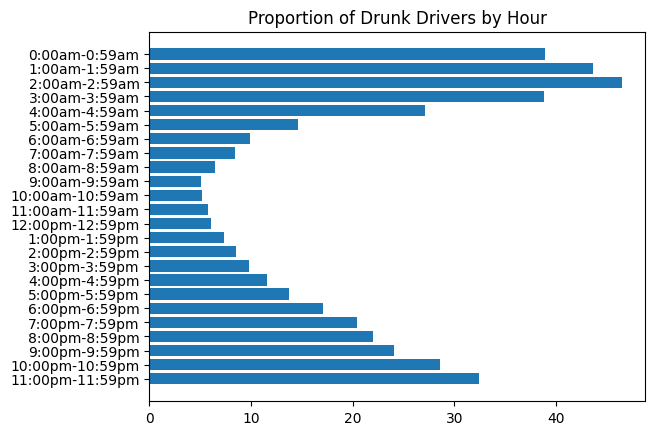

In [153]:
# Percent of drunk drivers in fatal accidents by the hour with SEVERITY = 0
query_percent_drunk_hours  = "SELECT SUM(number_of_drunk_drivers)/SUM(number_of_motor_vehicles_in_transport_mvit) * 100 as percent_drunk, SUM(number_of_drunk_drivers) AS num_drunk, SUM(number_of_motor_vehicles_in_transport_mvit) AS num_cars, COUNT(*) AS num_crashes, hour_of_crash_name  FROM `traffic_fatalities.traffic_features` GROUP BY hour_of_crash_name ORDER BY CASE WHEN hour_of_crash_name = '0:00am-0:59am' THEN 0 WHEN hour_of_crash_name = '1:00am-1:59am' THEN 1 WHEN hour_of_crash_name = '2:00am-2:59am' THEN 2 WHEN hour_of_crash_name = '3:00am-3:59am' THEN 3 WHEN hour_of_crash_name = '4:00am-4:59am' THEN 4 WHEN hour_of_crash_name = '5:00am-5:59am' THEN 5 WHEN hour_of_crash_name = '6:00am-6:59am' THEN 6 WHEN hour_of_crash_name = '7:00am-7:59am' THEN 7 WHEN hour_of_crash_name = '8:00am-8:59am' THEN 8 WHEN hour_of_crash_name = '9:00am-9:59am' THEN 9 WHEN hour_of_crash_name = '10:00am-10:59am' THEN 10 WHEN hour_of_crash_name = '11:00am-11:59am' THEN 11 WHEN hour_of_crash_name = '12:00pm-12:59pm' THEN 12 WHEN hour_of_crash_name = '1:00pm-1:59pm' THEN 13 WHEN hour_of_crash_name = '2:00pm-2:59pm' THEN 14 WHEN hour_of_crash_name = '3:00pm-3:59pm' THEN 15 WHEN hour_of_crash_name = '4:00pm-4:59pm' THEN 16 WHEN hour_of_crash_name = '5:00pm-5:59pm' THEN 17 WHEN hour_of_crash_name = '6:00pm-6:59pm' THEN 18 WHEN hour_of_crash_name = '7:00pm-7:59pm' THEN 19 WHEN hour_of_crash_name = '8:00pm-8:59pm' THEN 20 WHEN hour_of_crash_name = '9:00pm-9:59pm' THEN 21 WHEN hour_of_crash_name = '10:00pm-10:59pm' THEN 22 WHEN hour_of_crash_name = '11:00pm-11:59pm' THEN 23 END DESC"

percent_drunk_hours = pd.read_gbq(query_percent_drunk_hours, project_id=project_id, dialect='standard')

plt.barh(percent_drunk_hours["hour_of_crash_name"], percent_drunk_hours["percent_drunk"])
plt.title("Proportion of Drunk Drivers by Hour")

In [154]:
%%bigquery --project $project_id
SELECT SUM(number_of_drunk_drivers)/SUM(number_of_motor_vehicles_in_transport_mvit) * 100 as percent_drunk, SUM(number_of_drunk_drivers) AS num_drunk, SUM(number_of_motor_vehicles_in_transport_mvit) AS num_cars, COUNT(*) AS num_crashes, day_of_week_name 
FROM `traffic_fatalities.traffic_features` 
GROUP BY day_of_week_name
ORDER BY percent_drunk DESC

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,percent_drunk,num_drunk,num_cars,num_crashes,day_of_week_name
0,26.650516,12211,45819,31594,Sunday
1,25.143011,13054,51919,35100,Saturday
2,16.911421,8326,49233,31494,Friday
3,13.882687,5969,42996,27479,Thursday
4,13.405258,5492,40969,26252,Monday
5,13.031168,5339,40971,26056,Wednesday
6,12.629996,5040,39905,25490,Tuesday


- AS expected proprotion of drunk drivers involved in fatal accidents increase drastically on the weekends

Text(0.5, 1.0, 'Proportion of Drunk Drivers by Day of Week')

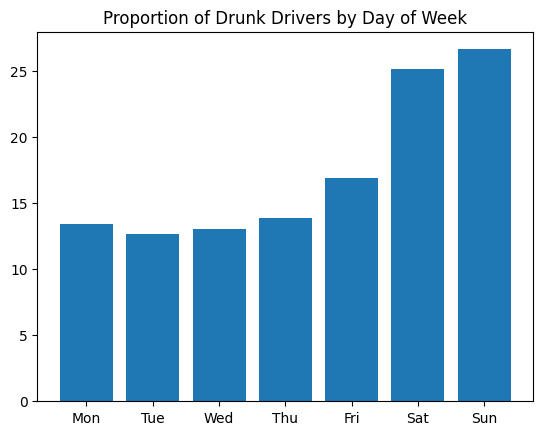

In [155]:
# Percent of drunk drivers in fatal accidents by the hour with SEVERITY = 0
query_percent_drunk_days  = "SELECT SUM(number_of_drunk_drivers)/SUM(number_of_motor_vehicles_in_transport_mvit) * 100 as percent_drunk, SUM(number_of_drunk_drivers) AS num_drunk, SUM(number_of_motor_vehicles_in_transport_mvit) AS num_cars, COUNT(*) AS num_crashes, day_of_week_name FROM `traffic_fatalities.traffic_features` GROUP BY day_of_week_name ORDER BY CASE WHEN day_of_week_name = 'Moday' THEN 0 WHEN day_of_week_name = 'Tuesday' THEN 1 WHEN day_of_week_name = 'Wednesday' THEN 3 WHEN day_of_week_name = 'Thursday' THEN 4 WHEN day_of_week_name = 'Friday' THEN 5 WHEN day_of_week_name = 'Saturday' THEN 6 WHEN day_of_week_name = 'Sunday' THEN 7 END"

percent_drunk_days = pd.read_gbq(query_percent_drunk_days, project_id=project_id, dialect='standard')

plt.bar(days, percent_drunk_days["percent_drunk"])
plt.title("Proportion of Drunk Drivers by Day of Week")

- We see that proportion of drunk drivers increase during the Summer months, this may be due to the fact that is it is Summer holidays for college, and also the fact that many in the workforce take vacations during this time

In [158]:
%%bigquery --project $project_id
SELECT SUM(number_of_drunk_drivers)/SUM(number_of_motor_vehicles_in_transport_mvit) * 100 as percent_drunk, SUM(number_of_drunk_drivers) AS num_drunk, SUM(number_of_motor_vehicles_in_transport_mvit) AS num_cars, COUNT(*) AS num_crashes, month_of_crash_name 
FROM `traffic_fatalities.traffic_features` 
GROUP BY month_of_crash_name
ORDER BY percent_drunk DESC

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,percent_drunk,num_drunk,num_cars,num_crashes,month_of_crash_name
0,18.899102,5387,28504,18696,July
1,18.883975,5039,26684,17423,May
2,18.794785,5377,28609,18651,August
3,18.699677,4343,23225,15131,April
4,18.359612,5135,27969,18024,June
5,17.929799,4204,23447,15198,March
6,17.797057,5067,28471,18614,September
7,17.603159,3656,20769,13606,February
8,16.846242,3815,22646,14837,January
9,16.500566,4371,26490,17379,November


- This is perhaps the most interesting statistic in this section
- We see that on average, when more drunk drivers are involved in fatal accidents the average amount of fatalities increase drastically
- And the difference here is statistically different to just increases in the number of drivers

In [163]:
%%bigquery --project $project_id
SELECT AVG(number_of_fatalities) AS avg_fatalities, number_of_motor_vehicles_in_transport_mvit AS num_drivers
FROM `traffic_fatalities.traffic_features` 
GROUP BY num_drivers
ORDER BY num_drivers
LIMIT 5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_fatalities,num_drivers
0,1.047758,1
1,1.130342,2
2,1.163290,3
3,1.195554,4
4,1.263291,5


In [159]:
%%bigquery --project $project_id
SELECT AVG(number_of_fatalities) AS avg_fatalities, number_of_drunk_drivers AS num_dd
FROM `traffic_fatalities.traffic_features` 
GROUP BY num_dd
ORDER BY num_dd

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_fatalities,num_dd
0,1.077975,0
1,1.105633,1
2,1.298685,2
3,1.333333,3
4,3.333333,4


Text(0.5, 1.0, 'Average Fatalities Given Number of Drunk Drivers')

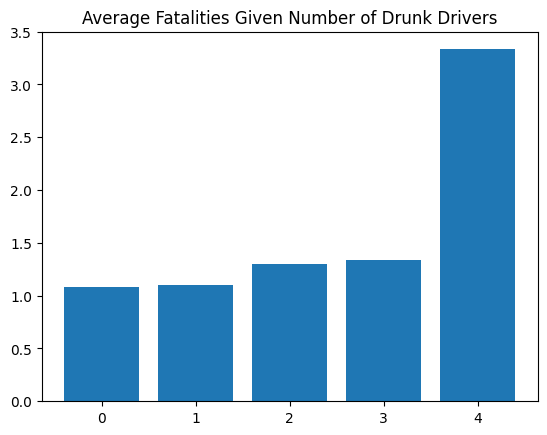

In [164]:
query_avg_dd  = "SELECT AVG(number_of_fatalities) AS avg_fatalities, number_of_drunk_drivers AS num_dd FROM `traffic_fatalities.traffic_features` GROUP BY num_dd ORDER BY num_dd"

avg_dd = pd.read_gbq(query_avg_dd, project_id=project_id, dialect='standard')

plt.bar(avg_dd["num_dd"], avg_dd["avg_fatalities"])
plt.title("Average Fatalities Given Number of Drunk Drivers")

- Here we see that the % of drunk drivers vary drastically from state to state
- Interestingly we see higher incidence of drunk drivers in fatal accidents in the Midwest and the North East
- This may be due to differences in alcohol related laws and accessibility - however this is contrary to the higher concentrations in the North-East where drinking laws are typically more strict
- We also think that in more rural states like those in the midwest, volume of alcohol consumption may be higher
- Finally there simply might just be cultural differences from state to state

In [168]:
query_percent_drunk_drivers_per_state = "SELECT SUM(number_of_drunk_drivers)/SUM(number_of_motor_vehicles_in_transport_mvit) * 100 as percent_drunk, SUM(number_of_drunk_drivers) AS num_drunk, SUM(number_of_motor_vehicles_in_transport_mvit) AS num_cars, COUNT(*) AS num_crashes, t.state_name, s.state FROM `traffic_fatalities.traffic_features` AS t JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON t.state_name = s.state_name GROUP BY state_name, state"
percent_drunk_drivers_per_state = pd.read_gbq(query_percent_drunk_drivers_per_state, project_id=project_id, dialect='standard')
fig_percent_drunk_drivers_per_state = px.choropleth(
    percent_drunk_drivers_per_state,
    locations='state',
    locationmode='USA-states',
    color='percent_drunk',
    color_continuous_scale = 'Reds',
    title='Percent Drunk Drivers by State',
)

fig_percent_drunk_drivers_per_state.update_layout(
    title_text = 'Percent Drunk Drivers by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': 'state=%{location}<br>percent_drunk=%{z}<extra></extra>',
              'locationmode': 'USA-states',
              'locations': array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI',
                                  'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
                                  'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH',
                                  'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA',
                                  'WV', 'WI', 'WY'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([17.33658662, 24.86288848, 15.59326232, 17.82570423, 18.67695487,
                          22.09368481, 23.38160136, 16.91871456, 19.23076923, 14.37538551,
                          13.69097091, 22.14199759, 20.87614927, 19.25363276, 12.68464562,
                          17.35273243, 12.93866341, 16.6180758 , 21.61143396, 26.88870837,
                          18.63019599, 21.10157368, 18.59605911, 20.00605327, 13.19470004,
                          18.30082136, 35.38350217, 19.04500549, 18.87755102, 21.8220339 ,
                          14.95655772, 19.78417266, 13.90432472, 17.70358306, 28.91278375,
                          21.03150712, 17.39130435, 20.0418629 , 17.12795828, 30.06263048,
                          21.89119171, 25.53648069, 15.61085973, 16.76137265, 13.10285958,
                          23.56687898, 21.04559632, 21.629094  , 18.46906987, 23.53309668,
                          23.34352701])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'percent_drunk'}},
                             'colorscale': [[0.0, 'rgb(255,245,240)'], [0.125,
                                            'rgb(254,224,210)'], [0.25,
                                            'rgb(252,187,161)'], [0.375,
                                            'rgb(252,146,114)'], [0.5,
                                            'rgb(251,106,74)'], [0.625,
                                            'rgb(239,59,44)'], [0.75,
                                            'rgb(203,24,29)'], [0.875,
                                            'rgb(165,15,21)'], [1.0,
                                            'rgb(103,0,13)']]},
               'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}, 'scope': 'usa'},
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Percent Drunk Drivers by State 2015-2020'}}
})

- As you can see here, the number of drunk drivers involved in fatal crashes per capita has a strong correlation with the amount of fatal crashes per capita on a state by state basis

Text(0, 0.5, 'drunk_drivers_per_cap_per_year')

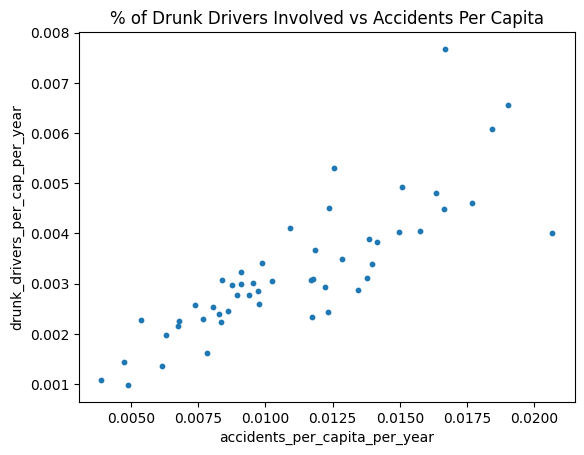

In [264]:
query_atmos = "WITH state_accidents AS (SELECT COUNT(*) AS num_accidents, state_name, state_number, SUM(number_of_drunk_drivers) AS numdrunk,  FROM `traffic_fatalities.traffic_features` GROUP BY state_name, state_number) SELECT drunk_drivers_per_cap, accidents_per_capita_per_year, t.state_name, s.state FROM `traffic_fatalities.traffic_features` AS t JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON t.state_name = s.state_name  JOIN(SELECT f.num_accidents / p.total_pop / 6 * 100 AS accidents_per_capita_per_year, f.numdrunk/p.total_pop/ 6 *100 as drunk_drivers_per_cap, f.state_name, s.state FROM state_accidents AS f JOIN `bigquery-public-data.census_bureau_acs.state_2020_5yr` AS p ON  f.state_number = CAST(p.geo_id AS INT64) JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name ORDER BY accidents_per_capita_per_year DESC) AS percap ON t.state_name = percap.state_name GROUP BY state_name, state, accidents_per_capita_per_year, drunk_drivers_per_cap ORDER BY drunk_drivers_per_cap DESC"
time_to_scene = pd.read_gbq(query_atmos, project_id=project_id, dialect='standard')
plt.scatter(time_to_scene["accidents_per_capita_per_year"], time_to_scene["drunk_drivers_per_cap"], s=10)
plt.title("% of Drunk Drivers Involved vs Accidents Per Capita")
plt.xlabel("accidents_per_capita_per_year")
plt.ylabel("drunk_drivers_per_cap_per_year")

### Atmospheric Conditions

- We also wonder how unfavourable atmoshperic conditions contribute to the severity of fatal accidents. Does snow, rain etc. result in higher average fatalities per fatal accident?

- Below we see that differences in certain atmospheric conditions and it's effect on avg_fatalities is quite small. However we wonder if these differences are statistically significant. Moreover do states with higher rates of unfavourable conditions have higher fatalities per accident?
- We decided to label blowing sand, sleet/hail, fog/smoke, rain, severe crosswinds, freezing rain or drizzle, snow and blowing snow as being unfavourable conditions. We thought that conditions such as cloudy, and clear would have very little effect
- In the query below we see that average fatalities increase in unfavourable conditions as opposed to "clear" conditions. But we are not sure if this is statistically significant. However we are deciding to include this feature, as some individual conditions like blowing sand increase average fatalities significantly. However it would be interesting to compare the incidence of fatal accidents in unfavourable conditions and favourable conditions, controlling for how commonly they occur - this is something we would've liked to explore further

In [223]:
%%bigquery --project $project_id
SELECT AVG(number_of_fatalities) AS avg_fatalities, COUNT(*) AS num_accidents, atmospheric_conditions_name
FROM `traffic_fatalities.traffic_features` 
GROUP BY atmospheric_conditions_name
ORDER BY avg_fatalities DESC

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_fatalities,num_accidents,atmospheric_conditions_name
0,1.200000,65,"Blowing Sand, Soil, Dirt"
1,1.105413,351,Sleet or Hail
2,1.098940,2264,"Fog, Smog, Smoke"
3,1.097624,15027,Rain
4,1.094406,286,Severe Crosswinds
5,1.090909,154,Freezing Rain or Drizzle
6,1.089575,1976,Snow
7,1.088361,29685,Cloudy
8,1.086324,141339,Clear
9,1.085791,373,Unknown


In [236]:
%%bigquery --project $project_id
WITH state_accidents AS (SELECT COUNT(*) AS num_accidents, state_name, state_number FROM `traffic_fatalities.traffic_features` GROUP BY state_name, state_number)
SELECT COUNT(*)/t.total_accidents_per_state * 100 AS percent_unfavorable, accidents_per_capita_per_year, w.state_name, s.state
FROM `traffic_fatalities.traffic_features` AS w
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name 
JOIN (SELECT COUNT(*) AS total_accidents_per_state, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name
JOIN(SELECT f.num_accidents / p.total_pop / 6 * 100 AS accidents_per_capita_per_year, f.state_name, s.state
FROM state_accidents AS f
JOIN `bigquery-public-data.census_bureau_acs.state_2020_5yr` AS p ON  f.state_number = CAST(p.geo_id AS INT64)
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name
ORDER BY accidents_per_capita_per_year DESC) AS percap ON w.state_name = percap.state_name
WHERE atmospheric_conditions_name IN ('Blowing Snow', 'Blowing Sand, Soil, Dirt', 'Sleet or Hail', 'Fog, Smog, Smoke', 'Rain', 'Severe Crosswinds', 'Freezing Rain or Drizzle', 'Snow')
GROUP BY state_name, state, total_accidents_per_state, accidents_per_capita_per_year


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,percent_unfavorable,accidents_per_capita_per_year,state_name,state
0,11.496245,0.017688,Alabama,AL
1,19.137466,0.008390,Alaska,AK
2,3.172492,0.012229,Arizona,AZ
3,12.936482,0.016640,Arkansas,AR
4,5.470750,0.008602,California,CA
5,5.189798,0.009886,Colorado,CO
6,10.399493,0.007361,Connecticut,CT
7,9.795322,0.011781,Delaware,DE
8,7.036868,0.013764,Florida,FL
9,10.058962,0.013439,Georgia,GA


- Here we do not see a correlation between accidents per capita and % of accidents in unfavourable conditions
- This may be due to the fact we are not looking at the amount of days where these unfavourable conditions occur, instead of just looking at accidents where these occur - therefore this chart really doesn't have a lot of meaning
- However we still believe atmospheric conditions have a strong impact on drivers and thus rate of accidents and decided to include this feature regardless in our model

Text(0, 0.5, 'accidents_per_capita_per_year')

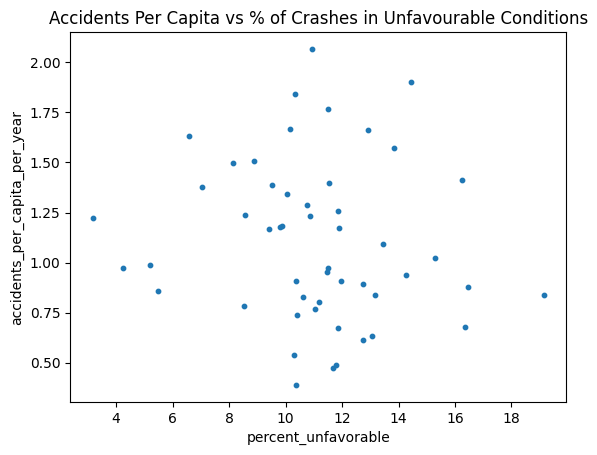

In [244]:
query_atmos = "WITH state_accidents AS (SELECT COUNT(*) AS num_accidents, state_name, state_number FROM `traffic_fatalities.traffic_features` GROUP BY state_name, state_number) SELECT COUNT(*)/t.total_accidents_per_state * 100 AS percent_unfavorable, accidents_per_capita_per_year * 100 as accidents_per_cap_per_year, w.state_name, s.state FROM `traffic_fatalities.traffic_features` AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name  JOIN (SELECT COUNT(*) AS total_accidents_per_state, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name JOIN(SELECT f.num_accidents / p.total_pop / 6 * 100 AS accidents_per_capita_per_year, f.state_name, s.state FROM state_accidents AS f JOIN `bigquery-public-data.census_bureau_acs.state_2020_5yr` AS p ON  f.state_number = CAST(p.geo_id AS INT64) JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON f.state_name = s.state_name ORDER BY accidents_per_capita_per_year DESC) AS percap ON w.state_name = percap.state_name WHERE atmospheric_conditions_name IN ('Blowing Snow', 'Blowing Sand, Soil, Dirt', 'Sleet or Hail', 'Fog, Smog, Smoke', 'Rain', 'Severe Crosswinds', 'Freezing Rain or Drizzle', 'Snow') GROUP BY state_name, state, total_accidents_per_state, accidents_per_capita_per_year"
time_to_scene = pd.read_gbq(query_atmos, project_id=project_id, dialect='standard')
plt.scatter(time_to_scene["percent_unfavorable"], time_to_scene["accidents_per_cap_per_year"], s=10)
plt.title("Accidents Per Capita vs % of Crashes in Unfavourable Conditions")
plt.xlabel("percent_unfavorable")
plt.ylabel("accidents_per_capita_per_year")

In [171]:
%%bigquery --project $project_id
SELECT COUNT(*)/t.total_accidents_per_state * 100 AS percent_unfavorable, COUNT(*) AS num_unfavorable, AVG(w.number_of_fatalities) AS avg_fatalities, w.state_name, s.state
FROM `traffic_fatalities.traffic_features` AS w
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name 
JOIN (SELECT COUNT(*) AS total_accidents_per_state, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name
WHERE atmospheric_conditions_name = 'Blowing Snow' OR atmospheric_conditions_name = 'Blowing Sand, Soil, Dirt' OR atmospheric_conditions_name = 'Sleet or Hail' OR atmospheric_conditions_name = 'Fog, Smog, Smoke' OR atmospheric_conditions_name = 'Rain' OR atmospheric_conditions_name = 'Severe Crosswinds'  OR atmospheric_conditions_name = 'Freezing Rain or Drizzle'  OR atmospheric_conditions_name = 'Snow'
GROUP BY state_name, state, total_accidents_per_state

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,percent_unfavorable,num_unfavorable,avg_fatalities,state_name,state
0,11.496245,597,1.105528,Alabama,AL
1,19.137466,71,1.056338,Alaska,AK
2,3.172492,167,1.143713,Arizona,AZ
3,12.936482,389,1.092545,Arkansas,AR
4,5.470750,1111,1.091809,California,CA
5,5.189798,175,1.114286,Colorado,CO
6,10.399493,164,1.048780,Connecticut,CT
7,9.795322,67,1.044776,Delaware,DE
8,7.036868,1233,1.098135,Florida,FL
9,10.058962,853,1.082063,Georgia,GA


- We see there is a lack in correlation between the percentage of accidents that occur in unfavourable conditions and the average number of fatalities per accident in unfavourable conditions by state
- This may be simply due to the fact that different types of conditions may have more of an effect than others
- Nevertheless when compared to average amount of fatalities for all accidents despite conditions, we see that accidents in unfavourable coniditions have higher fatality rates especially on the high-end among the states. Therefore this feature will be useful

In [245]:
query_unfavorable_per_state = "SELECT COUNT(*)/t.total_accidents_per_state * 100 AS percent_unfavorable, COUNT(*) AS num_unfavorable, AVG(w.number_of_fatalities) AS avg_fatalities, w.state_name, s.state FROM `traffic_fatalities.traffic_features` AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name JOIN (SELECT COUNT(*) AS total_accidents_per_state, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name WHERE atmospheric_conditions_name = 'Blowing Snow' OR atmospheric_conditions_name = 'Blowing Sand, Soil, Dirt' OR atmospheric_conditions_name = 'Sleet or Hail' OR atmospheric_conditions_name = 'Fog, Smog, Smoke' OR atmospheric_conditions_name = 'Rain' OR atmospheric_conditions_name = 'Severe Crosswinds'  OR atmospheric_conditions_name = 'Freezing Rain or Drizzle'  OR atmospheric_conditions_name = 'Snow' GROUP BY state_name, state, total_accidents_per_state"
unfavorable_per_state = pd.read_gbq(query_unfavorable_per_state, project_id=project_id, dialect='standard')
fig_unfavorable_avg_fatalities = px.choropleth(
    unfavorable_per_state,
    locations='state',
    locationmode='USA-states',
    color='avg_fatalities',
    color_continuous_scale = 'Blues',
)
fig_unfavorable_avg_fatalities.update_layout(
    title_text = 'Average Fatalities in Accidents that have Unfavorable Conditions by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': 'state=%{location}<br>avg_fatalities=%{z}<extra></extra>',
              'locationmode': 'USA-states',
              'locations': array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID',
                                  'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS',
                                  'MO', 'MT', 'NE', 'NV', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR',
                                  'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY',
                                  'DC', 'SD', 'NH'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([1.10552764, 1.05633803, 1.14371257, 1.09254499, 1.09180918, 1.11428571,
                          1.04878049, 1.04477612, 1.09813463, 1.08206331, 1.02941176, 1.11382114,
                          1.11111111, 1.0875    , 1.11320755, 1.14529915, 1.07191781, 1.10933333,
                          1.07627119, 1.06269592, 1.069869  , 1.08592777, 1.07220217, 1.12376238,
                          1.08436214, 1.12962963, 1.22222222, 1.16      , 1.04796163, 1.16296296,
                          1.06666667, 1.09617613, 1.10294118, 1.08267717, 1.13148789, 1.09669211,
                          1.10295858, 1.05714286, 1.08591065, 1.07480916, 1.15404976, 1.06349206,
                          1.07407407, 1.07056799, 1.062     , 1.10040161, 1.09422492, 1.125     ,
                          1.        , 1.21428571, 1.05479452])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'avg_fatalities'}},
                             'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                            'rgb(222,235,247)'], [0.25,
                                            'rgb(198,219,239)'], [0.375,
                                            'rgb(158,202,225)'], [0.5,
                                            'rgb(107,174,214)'], [0.625,
                                            'rgb(66,146,198)'], [0.75,
                                            'rgb(33,113,181)'], [0.875,
                                            'rgb(8,81,156)'], [1.0,
                                            'rgb(8,48,107)']]},
               'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}, 'scope': 'usa'},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Average Fatalities in Accidents that have Unfavorable Conditions by State 2015-2020'}}
})

### Light Conditions
### WE REMOVE?
- Light condition is heavily correlated with time of day, and thus rate of drunk drivers
- Therefore we expect to see that when light is lower rate of fatal accidents and average fatalities per accident will increase 

In [175]:
%%bigquery --project $project_id
SELECT AVG(number_of_fatalities) AS avg_fatalities, COUNT(*) AS num_accidents, light_condition_name
FROM `traffic_fatalities.traffic_features` 
GROUP BY light_condition_name
ORDER BY avg_fatalities DESC

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_fatalities,num_accidents,light_condition_name
0,1.094868,55709,Dark - Not Lighted
1,1.090594,4912,Dusk
2,1.090386,96055,Daylight
3,1.089888,267,Unknown
4,1.082199,3893,Dawn
5,1.078049,205,Not Reported
6,1.068709,40533,Dark - Lighted
7,1.063630,1493,Dark - Unknown Lighting
8,1.051447,311,Reported as Unknown
9,1.045977,87,Other


- Surprisingly we see that average fatalities per crash is actually higher during the day time. Perhaps this is due to the fact that there are more cars on the road. But we doubt this difference is statistically significant
- However since most accidents occur at night (see heat map below), we figured that it would still be useful to include light_condition as a feature in our model

In [197]:
%%bigquery --project $project_id
SELECT AVG(w.number_of_fatalities) AS avg_fatalities_dark
FROM `traffic_fatalities.traffic_features` AS w
WHERE light_condition_name = 'Dark - Lighted' OR light_condition_name = 'Dusk' OR light_condition_name = 'Dark - Not Lighted' OR light_condition_name = 'Dawn' OR light_condition_name = 'Dark - Unknown Lighting'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_fatalities_dark
0,1.083818


In [198]:
%%bigquery --project $project_id
SELECT AVG(w.number_of_fatalities) AS avg_fatalities_light
FROM `traffic_fatalities.traffic_features` AS w
WHERE light_condition_name = 'Daylight'


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_fatalities_light
0,1.090386


- We see that states with higher population densities tend to have more fatal accidents at night than in more rural states
- This is perhaps due to the effects of rush hour after work (which is ususually at night) being more intensified in high population density areas
- Or it could be due to higher incidences of day-drinking etc.

In [199]:
query_daylight_per_state = "SELECT COUNT(*)/t.total_accidents_per_state * 100 AS percent_daylight, COUNT(*) AS num_daylight, AVG(w.number_of_fatalities) AS avg_fatalities, w.state_name, w.light_condition_name, s.state FROM `traffic_fatalities.traffic_features` AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name JOIN (SELECT COUNT(*) AS total_accidents_per_state, state_name FROM `traffic_fatalities.traffic_features` GROUP BY state_name) AS t ON w.state_name = t.state_name WHERE light_condition_name = 'Daylight' GROUP BY state_name, light_condition_name, state, total_accidents_per_state"
daylight_per_state = pd.read_gbq(query_daylight_per_state, project_id=project_id, dialect='standard')
fig_daylight_avg_fatalities = px.choropleth(
    daylight_per_state,
    locations='state',
    locationmode='USA-states',
    color='percent_daylight',
    color_continuous_scale = 'Blues',
)
fig_daylight_avg_fatalities.update_layout(
    title_text = 'Percent of Accidents that are daylight by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': 'state=%{location}<br>percent_daylight=%{z}<extra></extra>',
              'locationmode': 'USA-states',
              'locations': array(['AK', 'MI', 'TX', 'AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL',
                                  'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
                                  'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND',
                                  'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'UT', 'VT', 'VA', 'WA',
                                  'WV', 'WI', 'WY'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([49.59568733, 48.80042652, 41.87527995, 48.37280955, 44.31990881,
                          53.74127037, 40.03348434, 52.04626335, 45.40266328, 41.95906433,
                          31.70731707, 39.74432142, 48.98584906, 39.96509599, 56.90208668,
                          47.76679168, 50.69016776, 54.2888165 , 56.04089219, 54.93358634,
                          42.88083393, 54.89749431, 42.26666667, 46.04389995, 56.55660377,
                          49.35135135, 54.73808122, 53.8606403 , 56.81818182, 42.87330317,
                          58.19295559, 43.88159902, 46.88715953, 49.11851981, 50.54273238,
                          53.22862129, 50.71507151, 51.79125529, 50.09731413, 52.07294264,
                          42.94117647, 43.93966282, 56.04900459, 51.21693122, 56.72751859,
                          60.06097561, 50.18619934, 47.27034979, 57.3011734 , 54.65152949,
                          58.88554217])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'percent_daylight'}},
                             'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                            'rgb(222,235,247)'], [0.25,
                                            'rgb(198,219,239)'], [0.375,
                                            'rgb(158,202,225)'], [0.5,
                                            'rgb(107,174,214)'], [0.625,
                                            'rgb(66,146,198)'], [0.75,
                                            'rgb(33,113,181)'], [0.875,
                                            'rgb(8,81,156)'], [1.0,
                                            'rgb(8,48,107)']]},
               'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}, 'scope': 'usa'},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Percent of Accidents that are daylight by State 2015-2020'}}
})

## Emergency Response Time


- Finally we believe that time to scene/hospital will have a direct effect on the number of fatalities in a car accident. And we wonder if emergency response times vary significantly from state to state and if that mirrors the differences in average traffic fatalities per capita from state to state.
- We chose not to investigate time to hospital here, as many crashes where there are multiple dead may reduce urgency to get people to hospital as those who are injured have already passed
- Moreover we assume that time of arrival is very correlated with time to hospital
- And in a car accident situation, care from paramedics and other emergency services on the scene - we believe to be much better at prolonging life

- Sadly we do not see a strong correlation between emergency response time and number of fatalities 
- This is perhaps because in fatal accidents much of the fatalities may occur instantaneously due to the high velocity nature of car accidents. Nevertheless we wonder if there is a correlation between number of fatal accidents per capita and emergency response time

Text(0, 0.5, 'Number of Fatalities')

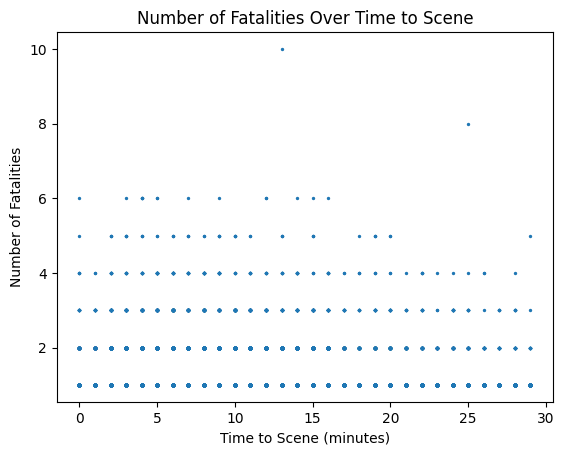

In [207]:
query_time_to_scene = "SELECT number_of_fatalities, time_to_scene FROM `traffic_fatalities.traffic_features` WHERE time_to_scene != 9999 AND time_to_scene <30"

time_to_scene = pd.read_gbq(query_time_to_scene, project_id=project_id, dialect='standard')

plt.scatter(time_to_scene["time_to_scene"], time_to_scene["number_of_fatalities"], s=2)
plt.title("Number of Fatalities Over Time to Scene")
plt.xlabel("Time to Scene (minutes)")
plt.ylabel("Number of Fatalities")

- To our satisfaction, we found quite a strong positive correlation between average time to scene and average fatalities per crash
- Therefore this indicates that the quality of emergency services and likelihood of being close to a hospital varies from state to state, and ultimatley has an impact on the number of fatalities

Text(0, 0.5, 'Average Number of Fatalities')

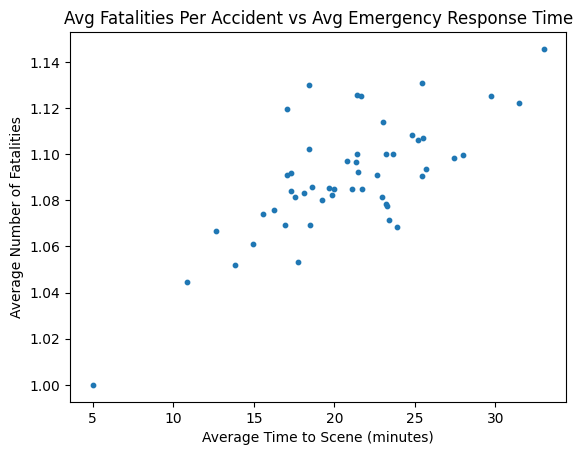

In [266]:
query_time_to_scene = "SELECT AVG(w.number_of_fatalities) AS avg_fatalities, AVG(w.time_to_scene) avg_time_to_scene, COUNT(*) AS count, s.state, w.state_name FROM `traffic_fatalities.traffic_features` AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name WHERE time_to_scene != 9999 GROUP BY state, state_name"

time_to_scene = pd.read_gbq(query_time_to_scene, project_id=project_id, dialect='standard')

plt.scatter(time_to_scene["avg_time_to_scene"], time_to_scene["avg_fatalities"], s=10)
plt.title("Avg Fatalities Per Accident vs Avg Emergency Response Time")
plt.xlabel("Average Time to Scene (minutes)")
plt.ylabel("Average Number of Fatalities")

- Here we see average emergency response time by state. As we can see, there is some variation in response time with no real regional consistencies. Perhaps this is due to just differences in spending on emergency services, in combination with average proximity to a hospital among states
- Surprisingly we noticed that the averaga response time in California was not great, this may be due to the sheer population size in this state, and therefore congestion may be limiting the ability of emergency vehicles to reach the scene quickly. Or perhaps it's due to the fact that compared to other states in the East Coast, cities are more spread out and thus on average it takes longer for emergency vehicles to arrive

In [220]:
query_tts_per_state = "SELECT AVG(w.number_of_fatalities) AS avg_fatalities, AVG(w.time_to_scene) avg_time_to_scene, COUNT(*) AS count, s.state, w.state_name FROM `traffic_fatalities.traffic_features` AS w JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name WHERE time_to_scene != 9999 GROUP BY state, state_name"
tts_per_state = pd.read_gbq(query_tts_per_state, project_id=project_id, dialect='standard')
fig_tts_per_state = px.choropleth(
    tts_per_state,
    locations='state',
    locationmode='USA-states',
    color='avg_time_to_scene',
    color_continuous_scale = 'Reds',
)

fig_tts_per_state.update_layout(
    title_text = 'Average Time to Scene by State 2015-2020',
    geo_scope='usa', # limite map scope to USA
)



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': 'state=%{location}<br>avg_time_to_scene=%{z}<extra></extra>',
              'locationmode': 'USA-states',
              'locations': array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI',
                                  'ID', 'IL', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS',
                                  'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK',
                                  'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV',
                                  'WI', 'WY', 'IN'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([21.44845722, 23.02013423, 18.43889971, 23.19561032, 27.42857143,
                          16.25563496, 17.76504298, 14.94876033, 10.82222222, 15.57116451,
                          18.58752041, 19.83542039, 25.18082422, 17.28342246, 23.66130884,
                          21.65529716, 21.3260101 , 22.95825427, 23.22336329, 21.69700599,
                          13.83606557, 17.03202377, 20.00105988, 17.03233533, 22.67162367,
                          27.98680203, 18.43333333, 18.09733124, 23.29699842, 16.91727941,
                          25.41506647, 17.3251551 , 19.20350433, 25.49344978, 17.55409283,
                          25.6811969 , 24.79162512, 18.50346356, 12.65151515, 19.64721845,
                          29.69877049, 21.11532007, 21.42633567, 25.44670051, 21.39032258,
                          23.38735632, 31.43803056, 23.8668942 , 20.77002967, 32.98596491,
                           5.        ])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'avg_time_to_scene'}},
                             'colorscale': [[0.0, 'rgb(255,245,240)'], [0.125,
                                            'rgb(254,224,210)'], [0.25,
                                            'rgb(252,187,161)'], [0.375,
                                            'rgb(252,146,114)'], [0.5,
                                            'rgb(251,106,74)'], [0.625,
                                            'rgb(239,59,44)'], [0.75,
                                            'rgb(203,24,29)'], [0.875,
                                            'rgb(165,15,21)'], [1.0,
                                            'rgb(103,0,13)']]},
               'geo': {'center': {}, 'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}, 'scope': 'usa'},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Average Time to Scene by State 2015-2020'}}
})

In [221]:
%%bigquery --project $project_id

SELECT AVG(w.number_of_fatalities) AS avg_fatalities, AVG(w.time_to_hospital) avg_time_to_hospital, COUNT(*) AS count, s.state, w.state_name
FROM `traffic_fatalities.traffic_features` AS w
JOIN `bigquery-public-data.geo_us_boundaries.states` AS s ON w.state_name = s.state_name 
WHERE time_to_hospital != 9999
GROUP BY state, state_name
ORDER BY avg_time_to_hospital DESC

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2153: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



,avg_fatalities,avg_time_to_hospital,count,state,state_name
0,1.138614,88.782178,404,WA,Washington
1,1.125926,87.470370,270,ND,North Dakota
2,1.104077,86.917382,1864,OK,Oklahoma
3,1.166090,86.837370,289,WY,Wyoming
4,1.067518,86.791971,548,VA,Virginia
5,1.110320,86.209964,562,MT,Montana
6,1.000000,85.333333,21,ID,Idaho
7,1.096518,82.594094,2269,LA,Louisiana
8,1.113312,82.283677,2524,KY,Kentucky
9,1.109375,81.927083,192,VT,Vermont


## Baseline and Data Prediction

### Training Time :D

In [ ]:
%%bigquery --project $project_id
SELECT COUNT(*)
FROM `traffic_fatalities.traffic_features`

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `traffic_fatalities.traffic_rand_data` AS
SELECT
    *,
    ROW_NUMBER() OVER(ORDER BY RAND()) AS rand_id
FROM `traffic_fatalities.traffic_features`

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE
CREATE OR REPLACE MODEL `traffic_fatalities.traffic_model`
OPTIONS(model_type='logistic_reg') AS
SELECT 
    id,
    state_name,
    number_of_motor_vehicles_in_transport_mvit,
    number_of_parked_working_vehicles,
    number_of_persons_in_motor_vehicles_in_transport_mvit,
    number_of_persons_not_in_motor_vehicles_in_transport_mvit,
    day_name,
    month_of_crash_name,
    day_of_week_name,
    hour_of_crash_name,
    land_use_name,
    light_condition_name, #should remove this from the model
    atmospheric_conditions_name,
    time_to_scene, 
    time_to_hospital,
    number_of_drunk_drivers,
    label
FROM `traffic_fatalities.traffic_rand_data`
WHERE rand_id <= 136942

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `traffic_fatalities.traffic_model`)

In [ ]:
%%bigquery --project $project_id
# YOUR QUERY HERE


SELECT
  *
FROM
  ML.EVALUATE(MODEL `traffic_fatalities.traffic_model`, (
      SELECT
        id,
        state_name,
        number_of_motor_vehicles_in_transport_mvit,
        number_of_parked_working_vehicles,
        number_of_persons_in_motor_vehicles_in_transport_mvit,
        number_of_persons_not_in_motor_vehicles_in_transport_mvit,
        day_name,
        month_of_crash_name,
        day_of_week_name,
        hour_of_crash_name,
        land_use_name,
        light_condition_name,
        atmospheric_conditions_name,
        time_to_scene,
        time_to_hospital,
        number_of_drunk_drivers,
        label,
      FROM `traffic_fatalities.traffic_rand_data`
      WHERE rand_id > 136942 AND rand_id <= 154060))

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT
  *
FROM
  ML.EVALUATE(MODEL `traffic_fatalities.traffic_model`, (
      SELECT
        id,
        state_name,
        number_of_motor_vehicles_in_transport_mvit,
        number_of_parked_working_vehicles,
        number_of_persons_in_motor_vehicles_in_transport_mvit,
        number_of_persons_not_in_motor_vehicles_in_transport_mvit,
        day_name,
        month_of_crash_name,
        day_of_week_name,
        hour_of_crash_name,
        land_use_name,
        light_condition_name,
        atmospheric_conditions_name,
        time_to_scene,
        time_to_hospital,
        number_of_drunk_drivers,
        label,
      FROM `traffic_fatalities.traffic_rand_data`
      WHERE rand_id > 154060
  ))

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT
  id,
  state_name,
  number_of_motor_vehicles_in_transport_mvit,
  number_of_parked_working_vehicles,
  number_of_persons_in_motor_vehicles_in_transport_mvit,
  number_of_persons_not_in_motor_vehicles_in_transport_mvit,
  day_name,
  month_of_crash_name,
  day_of_week_name,
  hour_of_crash_name,
  land_use_name,
  light_condition_name,
  atmospheric_conditions_name,
  time_to_scene,
  time_to_hospital,
  number_of_drunk_drivers,
  predicted_label
FROM
  ML.PREDICT(MODEL `traffic_fatalities.traffic_model`, (
  SELECT
    id,
    state_name,
    number_of_motor_vehicles_in_transport_mvit,
    number_of_parked_working_vehicles,
    number_of_persons_in_motor_vehicles_in_transport_mvit,
    number_of_persons_not_in_motor_vehicles_in_transport_mvit,
    day_name,
    month_of_crash_name,
    day_of_week_name,
    hour_of_crash_name,
    land_use_name,
    light_condition_name,
    atmospheric_conditions_name,
    time_to_scene,
    time_to_hospital,
    number_of_drunk_drivers,
  FROM `traffic_fatalities.traffic_features`
  WHERE number_of_motor_vehicles_in_transport_mvit > 2 AND number_of_persons_in_motor_vehicles_in_transport_mvit > 3 AND number_of_drunk_drivers > 2 AND time_to_scene >= 10
  ORDER BY RAND()))
LIMIT 10

In [ ]:
%%bigquery --project $project_id

SELECT id, label
FROM `traffic_fatalities.traffic_features`
WHERE id = '1217692018' OR id = '802382017' OR id = '3904462017' OR id = '3300362019' OR id = '2600512020' OR id = '629562018'

## Conclusion

---

*TODO: Final conclusions based on the rest of your project*

---